# All In One Place
---

    All In One Place Co. is a multi-brand company that seeks to sell various products at a competitive price and quality assurance. Recently, the marketing team discovered in database that some customers were buying more expensive products frequently. 
    Knowing this, the All In One Place team create a plan to develop a loyalty program for customers, the idea of the Insiders was created. Even with that information, the team isn't sure which customers will be assigned to the program, so the data team was called to cooperate. 
    It is up to the data team to answer the following questions: 
   - Who are the elegible people to participate in the “Insiders Program”?
   - How many clients will be part of the group?
   - Which are the main caracteristics for the group?
   - What is the revenue percentage that comes from the group?
   - Which are the guarantees that the “Insiders Program” is better than the rest of the base?



> Disclaimer: This is a fictional bussiness case

## PLANNING

### Tasks

1. Identify elegible costumers for Insiders?
    - How can a costumer become eligible? What is a High-Value costumer?
        - Revenue:
            - High ticket
            - High LT revenue
            - Low recency
            - High bascket size
            - High revenue forecast
            - High probabilty of pruchase

        - Cost:
            - Low return rate

        - Costumer experience:
            - High rating
    
2. How many costumers will be included into Insiders?
    - Total customers
    - Rate (%) of members to include in Insiders
        
3. Which are the main characteristics of those costumers?
    - Describe the customers attributes:
        - Age
        - Localization
     
    - Consumption behavior:
        - Same attributes for clustering
        
4. Which is the revenue of Insiders?
    - Total revenue
    - Revenue of Insiders members

5. Which is the revenue forecast for next months of Insiders?
    - LT revenue of Insiders members
    - Cohort analysis

6. What are the conditions to be included in Insiders?
    - Define the period of evualation (1 month, 3 months,...)
    - New members must have similar attributes of current members

7. What are the conditions to be removed in Insiders?
    - Define the period of evualation (1 month, 3 months,...)
    - Members to be removed must have different attributes of group

8. How can we garantee the Insiders program is better than others costumers?
    - A/B Test
    - A/B Bayesian
    - Hypothesis test

9. How can Marketing Dept. increase the revenue?
    - Discount
    - Purchase preference
    - Free freight
    - Company tour

### Benchmark

1. RFM Model
     - Recency
          - Time since the last purchase.
          - Responsivity.
           
     - Frequency
          - Avg time between transactions.
          - Engagement
            
      - Monetary
          - Gross revenues.
          - High value purchases.

## IMPORTS

In [1]:
import pickle
import warnings
import inflection

import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import umap.umap_               as umap
import matplotlib.pyplot        as plt
import matplotlib.ticker        as ticker
import sklearn.preprocessing    as pp
import sklearn.decomposition    as dd
import sklearn.ensemble         as en

from scipy.cluster                          import hierarchy
from sklearn.cluster                        import KMeans
from sklearn.mixture                        import GaussianMixture
from sklearn.metrics                        import silhouette_score
from sklearn.manifold                       import TSNE
from pandas_profiling                       import ProfileReport
from yellowbrick.cluster                    import KElbowVisualizer, SilhouetteVisualizer
from IPython.core.display                   import HTML, Image

## HELPER FUNCTIONS

In [2]:
def numerical_metrics(numerical_attributes):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
    
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns=['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes


def silhouette_score_result(clusters, model_list, color):
    """Generates a silhouette score of one model
    Args:
        clusters: [A list with clusters]
        model_list: [A list of the model labels info]
        color: [Color of the line]
    Returns:
        [Image]: [Silhouette Score]
    """

    ax = plt.plot(clusters, model_list, linestyle = '--', marker = 'o', color = color)
    plt.xlabel('Cluster')
    plt.xticks(clusters)
    plt.ylabel('Silhouette Score')
    plt.title('Result Comparation')

    return ax


def correlation_matrix(data, id, method):
    """Generates a correlation matrix of numerical variables

    Args:
        data ([DataFrame]): [The dataframe of the EDA]
        id ([string]): [The customer reference number]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    num_attributes = num_attributes.drop(columns = id )
    correlation = num_attributes.corr(method = method)

    # mask
    mask = np.zeros_like(correlation)
    mask = np.triu(np.ones_like(correlation, dtype = np.bool))

    # plot
    ax = sns.heatmap(correlation, mask = mask, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return ax
    

def plot_label(title, xlabel, ylabel, fontsize):
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    sns.set_context('notebook')


def snakecase(cols):
    change_snakecase = lambda x: inflection.underscore(x)
    return list(map(change_snakecase, cols))


def sum_of_na(data):
    return pd.DataFrame({'Sum of NA': data.isna().sum(), '% NA': data.isna().sum()/data.shape[0]})


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'tableau-colorblind10' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


# ignoring errors
warnings.filterwarnings('ignore')

# round
pd.options.display.float_format = '{:.3f}'.format

seed = 42

Populating the interactive namespace from numpy and matplotlib


## DATA

This dataset is avaliable in: https://www.kaggle.com/vik2012kvs/high-value-customers-identification

- **Data fields**
    - Invoice Number: Unique value from every transaction
    - Stock Code Product: Product code
    - Description: Product name
    - Quantity: The quantities of each product per transaction
    - Invoice Date: The day when the transaction was generated
    - Unit Price: Product price per unit
    - Customer ID: Unique ID to each customer
    - Country: Country name

In [3]:
homepath = '/home/guttofranca/Repos/pa005_insiders_clustering/insiders_clustering/'

In [4]:
df_raw = pd.read_csv(homepath + 'data/raw/Ecommerce.csv', encoding='cp1252' ,low_memory = False)

In [5]:
pickle.dump(df_raw, open(homepath + 'data/processed/df_raw.pkl', 'wb'))

## 1. DATA DESCRIPTION

- **Tasks**
    - Dataset Checkpoint
    - Check Data
    - Rename Columns
    - Data Dimensions
    - Data Types
    - Descriptive Statistics

### 1.1 Dataset Checkpoint

In [6]:
df1 = pickle.load(open(homepath + 'data/processed/df_raw.pkl', 'rb'))

In [7]:
df1.head().T

,0,1,2,3,4
InvoiceNo,536365,536365,536365,536365,536365
StockCode,85123A,71053,84406B,84029G,84029E
Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.
Quantity,6,6,8,6,6
InvoiceDate,29-Nov-16,29-Nov-16,29-Nov-16,29-Nov-16,29-Nov-16
UnitPrice,2.550,3.390,2.750,3.390,3.390
CustomerID,17850.000,17850.000,17850.000,17850.000,17850.000
Country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
Unnamed: 8,NaN,NaN,NaN,NaN,NaN


### 1.2 Organizing Columns

In [8]:
# changing to snakecase type
cols_new = snakecase(df1.columns)
df1.columns = cols_new

### 1.3 Data Dimensions

In [9]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 541909 
Number of columns: 9


### 1.4 Check Data

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
 8   unnamed: 8    0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [11]:
sum_of_na(df1)

,Sum of NA,% NA
invoice_no,0,0.000
stock_code,0,0.000
description,1454,0.003
quantity,0,0.000
invoice_date,0,0.000
unit_price,0,0.000
customer_id,135080,0.249
country,0,0.000
unnamed: 8,541909,1.000


The unnamed: 8 is empty in all rows, so I will drop that

### 1.5 Deal with NA

In [12]:
df1.drop(['unnamed: 8'], axis = 1, inplace = True)

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [14]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra column
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,United Kingdom,17850.000
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,United Kingdom,17850.000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,United Kingdom,17850.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,United Kingdom,17850.000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,United Kingdom,17850.000


In [15]:
sum_of_na(df1)

,Sum of NA,% NA
invoice_no,0,0.000
stock_code,0,0.000
description,1454,0.003
quantity,0,0.000
invoice_date,0,0.000
unit_price,0,0.000
country,0,0.000
customer_id,0,0.000


### 1.6 Unique values

In [16]:
print(f'There are {len(df1["invoice_no"].unique())} unique invoice numbers.')
print(f'There are {len(df1["stock_code"].unique())} diferent unique stock codes.')
print(f'There are {len(df1["description"].unique())} unique products descriptions.')
print(f'There are {len(df1["customer_id"].unique())} unique customers.')

There are 25900 unique invoice numbers.
There are 4070 diferent unique stock codes.
There are 4224 unique products descriptions.
There are 8082 unique customers.


### 1.7 Data Types

In [17]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

I've found some weird values in invoice_no column, some rows has a letter, like: C536479

1. `invoice_date`: Need to be converted from object to datetime64

In [18]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

2. `customer`: Need to be converted from float64 to int64

In [19]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [20]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.8 Ordering Columns

In [21]:
df1 = df1.reindex(columns=['customer_id', 'invoice_date', 'stock_code', 'description', 'unit_price', 'quantity', 'country', 'invoice_no'])
df1.head()

,customer_id,invoice_date,stock_code,description,unit_price,quantity,country,invoice_no
0,17850,2016-11-29,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.550,6,United Kingdom,536365
1,17850,2016-11-29,71053,WHITE METAL LANTERN,3.390,6,United Kingdom,536365
2,17850,2016-11-29,84406B,CREAM CUPID HEARTS COAT HANGER,2.750,8,United Kingdom,536365
3,17850,2016-11-29,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.390,6,United Kingdom,536365
4,17850,2016-11-29,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.390,6,United Kingdom,536365


### 1.9 Descriptive Statistics

#### 1.9.1 Numerical Attributes

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(columns='customer_id')
num_cols = num_attributes.columns.tolist()

In [23]:
num_attributes_result = numerical_metrics(num_attributes[num_cols])
num_attributes_result

,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,unit_price,-11062.060,38970.000,50032.060,4.611,2.080,1.250,4.130,96.760,186.507,59005.719
1,quantity,-80995.000,80995.000,161990.000,9.552,3.000,1.000,10.000,218.081,-0.264,119769.160


`Outliers in unit price and quantity`:

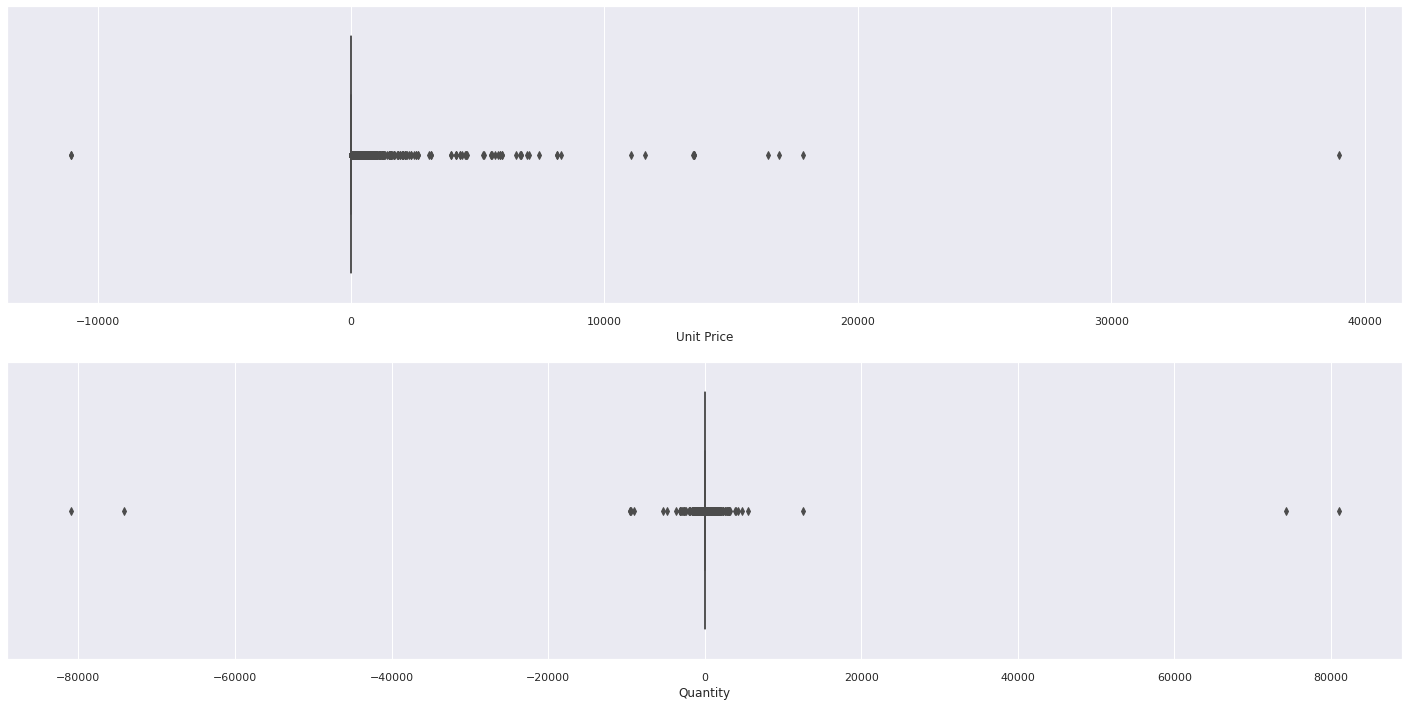

In [24]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

ax = sns.boxplot(df1['unit_price'], ax = ax1);
ax.set_xlabel('Unit Price', fontsize = 12);
ax = sns.boxplot(df1['quantity'], ax = ax2);
ax.set_xlabel('Quantity', fontsize = 12);

#saving figure
plt.savefig(homepath + 'reports/figures/num_attributes_outliers.png')

##### 1.9.1.1 Numerical Attributes Investigation

1. `Negative Quantity`: It could be devolutions
2. `Unit Price equal to 0`: Promotion?

#### 1.9.2 Categorical Attributes

1. `invoice_no`:

In [25]:
df_invoice_letter = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_invoice_letter.head()
print(f"Total number of invoices: {len(df_invoice_letter)}")
print(f"Total number of negative quantity: {len(df_invoice_letter[df_invoice_letter['quantity'] < 0])}")

Total number of invoices: 9291
Total number of negative quantity: 9288


2. `stock_code`:

In [26]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

3. `country`:

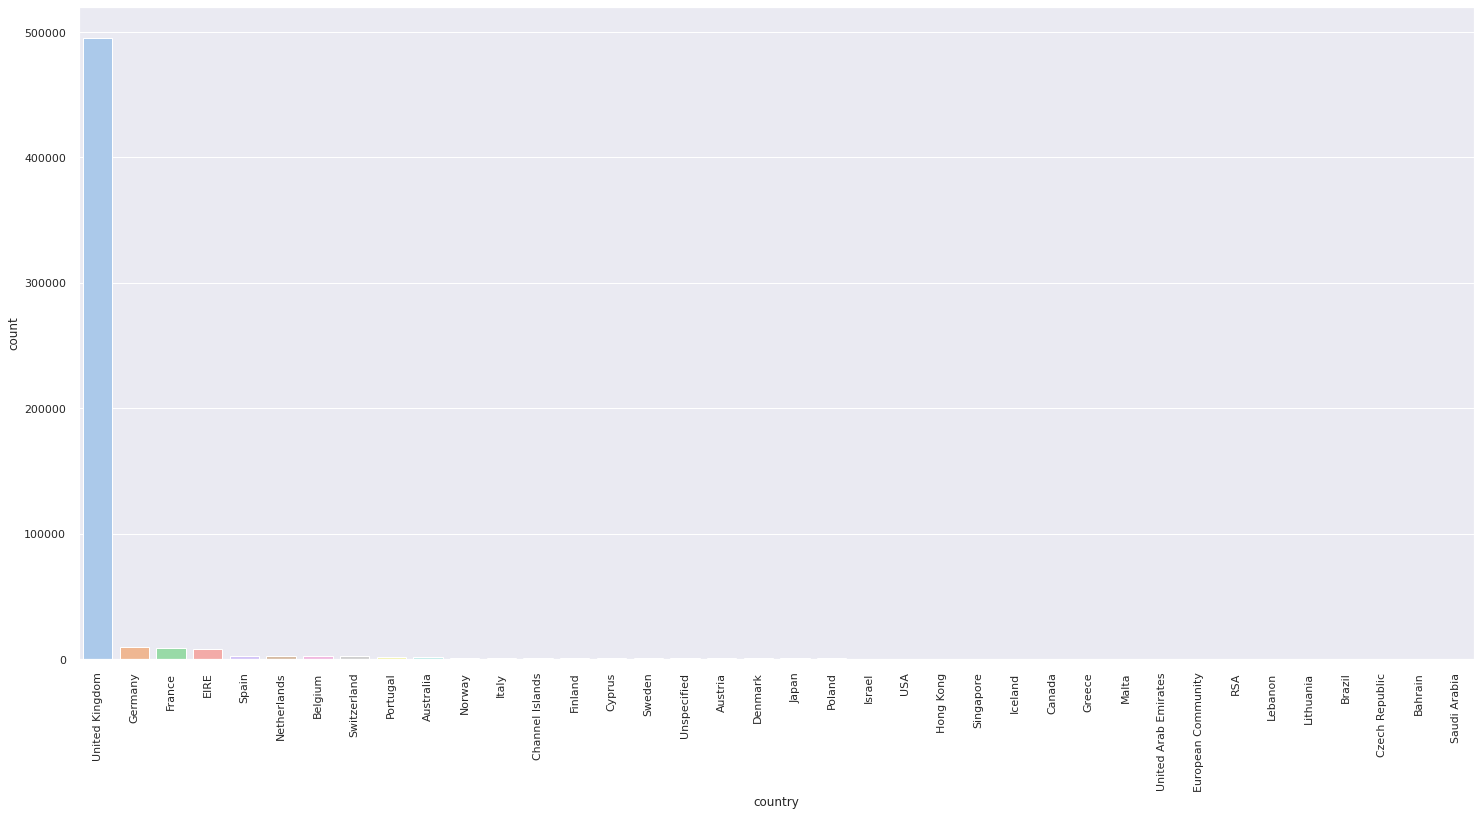

In [27]:
ax = sns.countplot(x = 'country', data = df1, palette = 'pastel', order = df1['country'].value_counts().index)
plt.xticks(rotation = 90);

# saving figure
plt.savefig(homepath + 'reports/figures/country_count_uk.png')

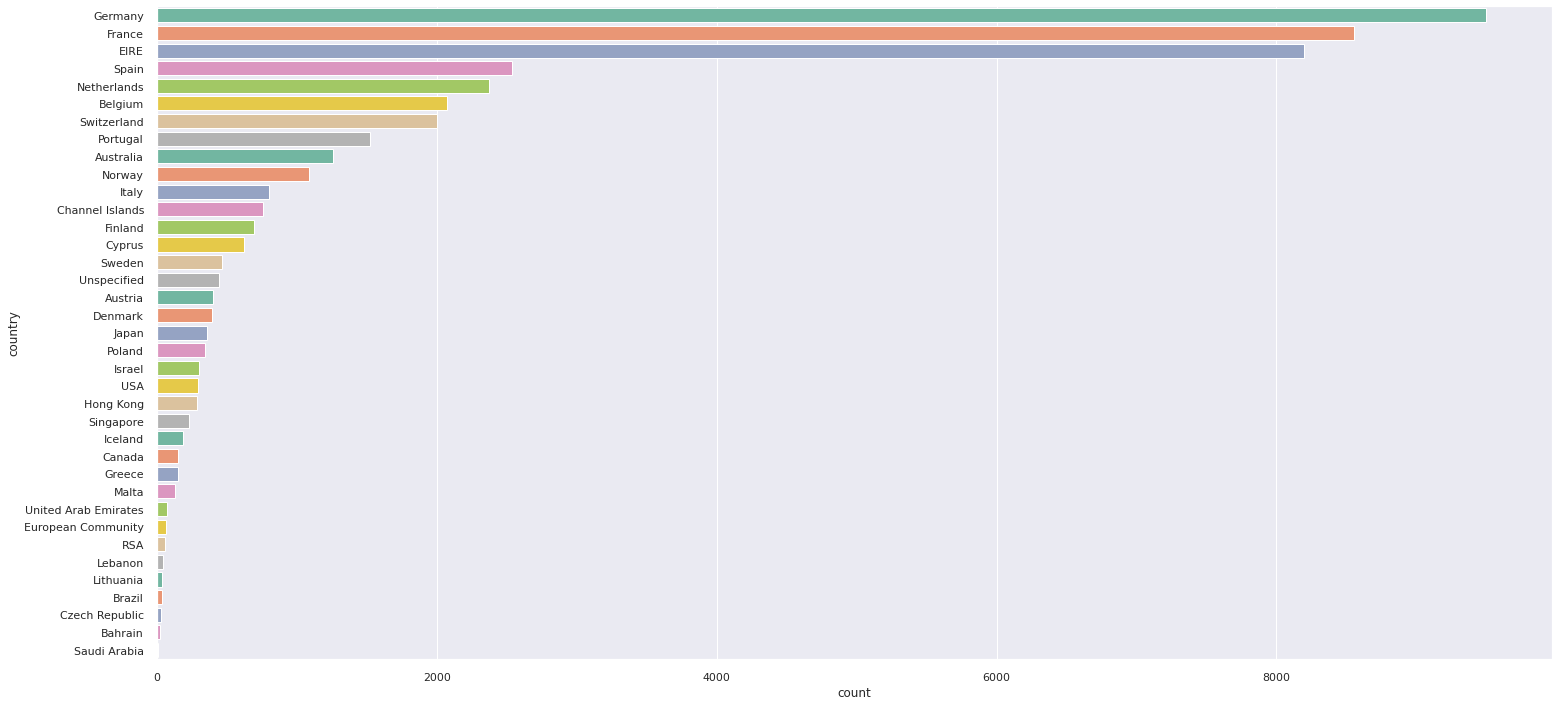

In [28]:
aux1 = df1[df1['country'] != 'United Kingdom']
aux2 = aux1[aux1['country'] != 'Unspecified']
ax = sns.countplot(y = 'country', data = aux1, palette = 'Set2', order = aux1['country'].value_counts().index)

# saving figure
plt.savefig(homepath + 'reports/figures/country_count.png')

#### 1.9.3 Date Attributes

In [29]:
print(f'First purchase: {df1["invoice_date"].min()}.')
print(f'Last purchase: {df1["invoice_date"].max()}.')

First purchase: 2016-11-29 00:00:00.
Last purchase: 2017-12-07 00:00:00.


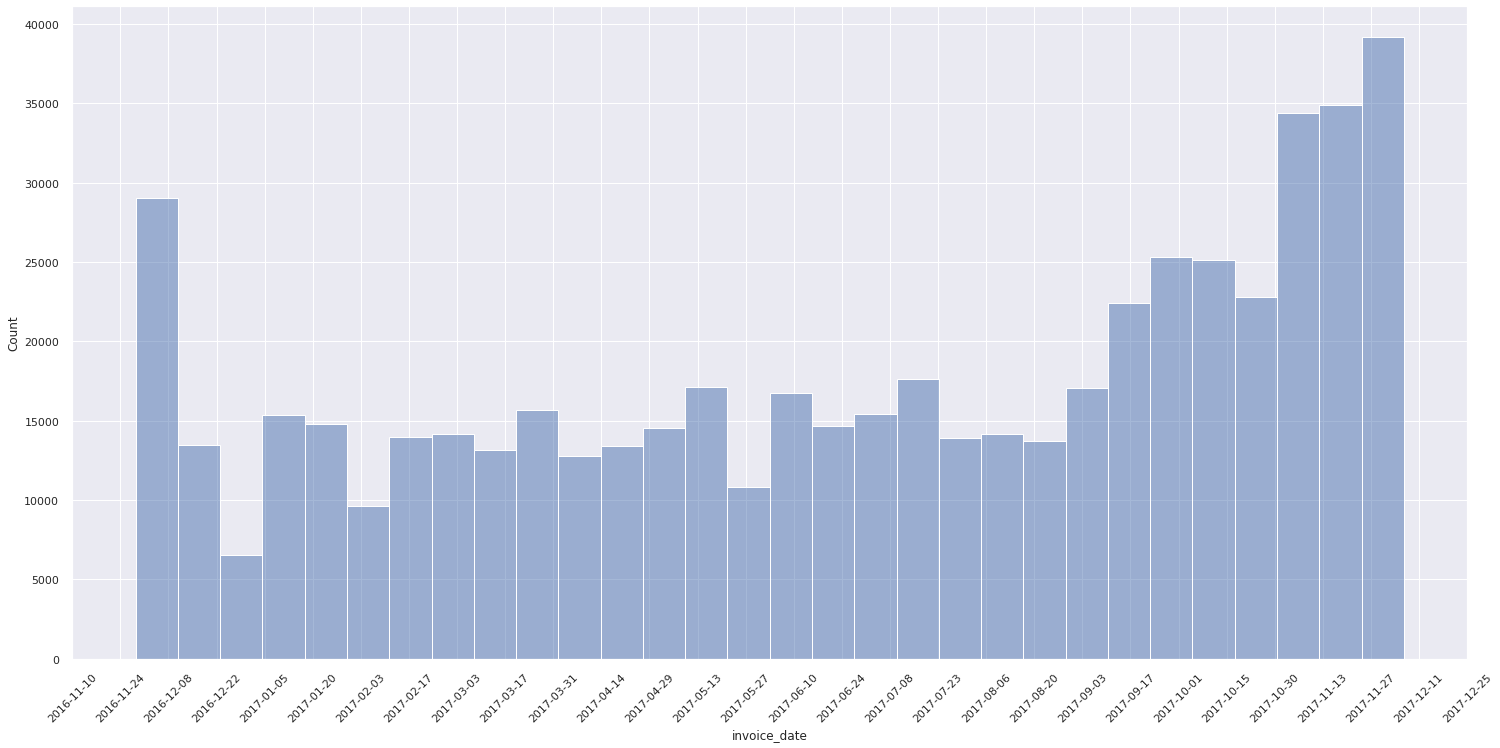

In [30]:
ax = sns.histplot(data = df1, x = 'invoice_date',bins = 30, alpha = 0.5);
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks = 30))

# saving figure
plt.savefig(homepath + 'reports/figures/countplot_date.png')

### 1.10 Save State

In [31]:
pickle.dump(df1, open(homepath + 'data/processed/df1.pkl', 'wb'))

## 2. VARIABLE FILTERING

- **Tasks**
    - Dataset Checkpoint
    - Filtering Rows
    - Save State

### 2.1 Dataset Checkpoint

In [32]:
df2 = pickle.load(open(homepath + 'data/processed/df1.pkl', 'rb'))

### 2.2 Filtering Rows and Columns

In [33]:
quantity_low = len(df2[df2['quantity'] < 1])
unit_price_low = len(df2[df2['unit_price'] <= 0])
print(f'There are {quantity_low} rows with product quantities in the cart less than 1 and {unit_price_low} rows with price equal or lower than 0')

There are 10624 rows with product quantities in the cart less than 1 and 2517 rows with price equal or lower than 0


Filtering `unit_price`, `quantity`,`stock_code`, `description`, `country`:

In [34]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# quantity
df_returns = df2.loc[df1['quantity'] < 0, :]
df_purchases = df2.loc[df1['quantity'] >= 0, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis=1)

# bad_users
df2 = df2[~df2['customer_id'].isin([16446])]

# country 
df2 = df2[ ~ df2['country'].isin(['European Community', 'Unspecified' ])]

### 2.3 Save State

In [35]:
pickle.dump(df2, open(homepath + 'data/processed/df2.pkl', 'wb'))
pickle.dump(df_returns, open(homepath + 'data/processed/df_returns.pkl', 'wb'))
pickle.dump(df_purchases, open(homepath + 'data/processed/df_purchases.pkl', 'wb'))

## 3. FEATURE ENGINEERING

- **Tasks**
    - Dataset Checkpoint
    - Features
    - Save State

### 3.1 Dataset Checkpoint

In [36]:
df3 = pickle.load(open(homepath + 'data/processed/df2.pkl', 'rb'))

### 3.2 Features

#### 1. Creating a reference dataframe:

In [37]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'country',
                   'unit_price'], axis = 1).drop_duplicates(ignore_index = True)

#### 2  . Creating `gross_revenue`:

In [38]:
df_purchases.loc[:, 'gross_revenue'] = df_purchases.loc[:, 'quantity'] * df_purchases.loc[:, 'unit_price']

#### 3. Creating `recency` - last day purchase:

In [39]:
df_recency = df_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(['invoice_date'], axis = 1, inplace = True)

# merge
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

#### 4. Creating `frequency`:

In [40]:
df_purchased = df_purchases.loc[:, ['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index()
df_purchased.columns = ['customer_id', 'frequency']

# merge
df_ref = pd.merge(df_ref, df_purchased, on = 'customer_id', how = 'left')

#### 5. Creating `monetary`:

In [41]:
df_monetary = df_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.columns = ['customer_id', 'monetary']

# merge
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')

#### 6. Creating `avg_ticket`:

In [42]:
# avg_ticket
df_avg_ticket = df_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_avg_ticket.columns = ['customer_id', 'avg_ticket']

# merge
df_ref = pd.merge( df_ref, df_avg_ticket, on = 'customer_id', how = 'left')

#### 7. Creating `quantity_of_products_purchased`:

In [43]:
df_qopp = df_purchases.loc[:, ['customer_id', 'stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qopp.columns = ['customer_id', 'quantity_of_products_purchased']

# merge
df_ref = pd.merge(df_ref, df_qopp, on = 'customer_id', how = 'left')

#### 8. Creating `quantity_of_items_purchased`:

In [44]:
df_qoip = df_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_qoip.columns = ['customer_id', 'quantity_of_items_purchased']

# merge
df_ref = pd.merge(df_ref, df_qoip, on = 'customer_id', how = 'left')

#### 9. Creating `purchase_frequency`:

In [45]:
df_pfreq = (df_purchases.loc[:,['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                                .agg( max_ = ('invoice_date', 'max'),
                                                                                      min_ = ('invoice_date', 'min'),
                                                                                      days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                                      buy_ = ('invoice_no', 'count')
                                                                                    )).reset_index()

# calculation
df_pfreq['purchase_frequency'] = df_pfreq[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 
                                                                                       else 0, axis = 1)
df_pfreq = df_pfreq[['customer_id', 'purchase_frequency']]

# merge
df_ref = pd.merge(df_ref, df_pfreq, on = 'customer_id', how = 'left')

#### 10. Creating `quantity_of_returns`:

In [46]:
df_qreturns = df_returns.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_qreturns.columns = ['customer_id', 'quantity_of_returns']
df_qreturns['quantity_of_returns'] = df_qreturns['quantity_of_returns'] * -1

# merge
df_ref = pd.merge(df_ref, df_qreturns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['quantity_of_returns'].isna(), 'quantity_of_returns'] = 0

#### 11. Creating `basket_size`:

In [47]:
df_basket_size = (df_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                                 .agg( n_purchase = ( 'invoice_no', 'nunique'),
                                                                                       n_products = ( 'quantity', 'sum') 
                                                                                      )).reset_index()

# calculation
df_basket_size['avg_basket_size'] = df_basket_size['n_products'] / df_basket_size['n_purchase']
df_basket_size = df_basket_size[['customer_id', 'avg_basket_size']]


# merge
df_ref = pd.merge( df_ref, df_basket_size, how = 'left', on = 'customer_id' )

#### 12. Creating `unique_basket_size`:

In [48]:
df_ubasket_size = (df_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                                   .agg( n_purchase = ( 'invoice_no', 'nunique'),
                                                                                         n_products = ( 'stock_code', 'count') 
                                                                                       )).reset_index()

# calculation
df_ubasket_size['avg_unique_basket_size'] = df_ubasket_size['n_products'] / df_ubasket_size['n_purchase']

df_ubasket_size = df_ubasket_size[['customer_id', 'avg_unique_basket_size']]

# merge
df_ref = pd.merge(df_ref, df_ubasket_size, how = 'left', on = 'customer_id')

#### 13. Creating `avg_recency_days`:

In [49]:
# Average recency days
df_aux = df2.loc[:, ['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis = 1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, how = 'left', on = 'customer_id')

### 3.3 Check Features NA

In [50]:
sum_of_na(df_ref)

,Sum of NA,% NA
customer_id,0,0.000
recency,90,0.016
frequency,90,0.016
monetary,90,0.016
avg_ticket,90,0.016
quantity_of_products_purchased,90,0.016
quantity_of_items_purchased,90,0.016
purchase_frequency,90,0.016
quantity_of_returns,0,0.000
avg_basket_size,90,0.016


In [51]:
df_ref = df_ref.dropna()

### 3.4 Save State

In [52]:
pickle.dump(df_ref, open(homepath + 'data/processed/df3.pkl', 'wb'))

## 4. EXPLORATORY DATA ANALYSIS

- **Tasks**
    - Dataset Checkpoint
    - Mind Map
    - Univariate Analysis
    - Bivariate Analysis
    - Multivariate Analysis
    - Dimensionality Reduction
    - Save State

### 4.1 Dataset Checkpoint

In [53]:
df4 = pickle.load(open(homepath + 'data/processed/df3.pkl', 'rb'))
df4.head()

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_products_purchased,quantity_of_items_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,avg_recency_days
0,17850,372.000,297.000,5391.210,18.152,21.000,1733.000,17.000,40.000,50.971,8.735,35.500
1,13047,31.000,172.000,3237.540,18.823,106.000,1391.000,0.029,36.000,139.100,17.200,27.250
2,12583,2.000,247.000,7281.380,29.479,115.000,5060.000,0.040,51.000,337.333,16.467,23.188
3,13748,95.000,28.000,948.250,33.866,24.000,439.000,0.018,0.000,87.800,5.600,92.667
4,15100,333.000,3.000,876.000,292.000,1.000,80.000,0.073,22.000,26.667,1.000,8.600


### 4.2 Mind Map

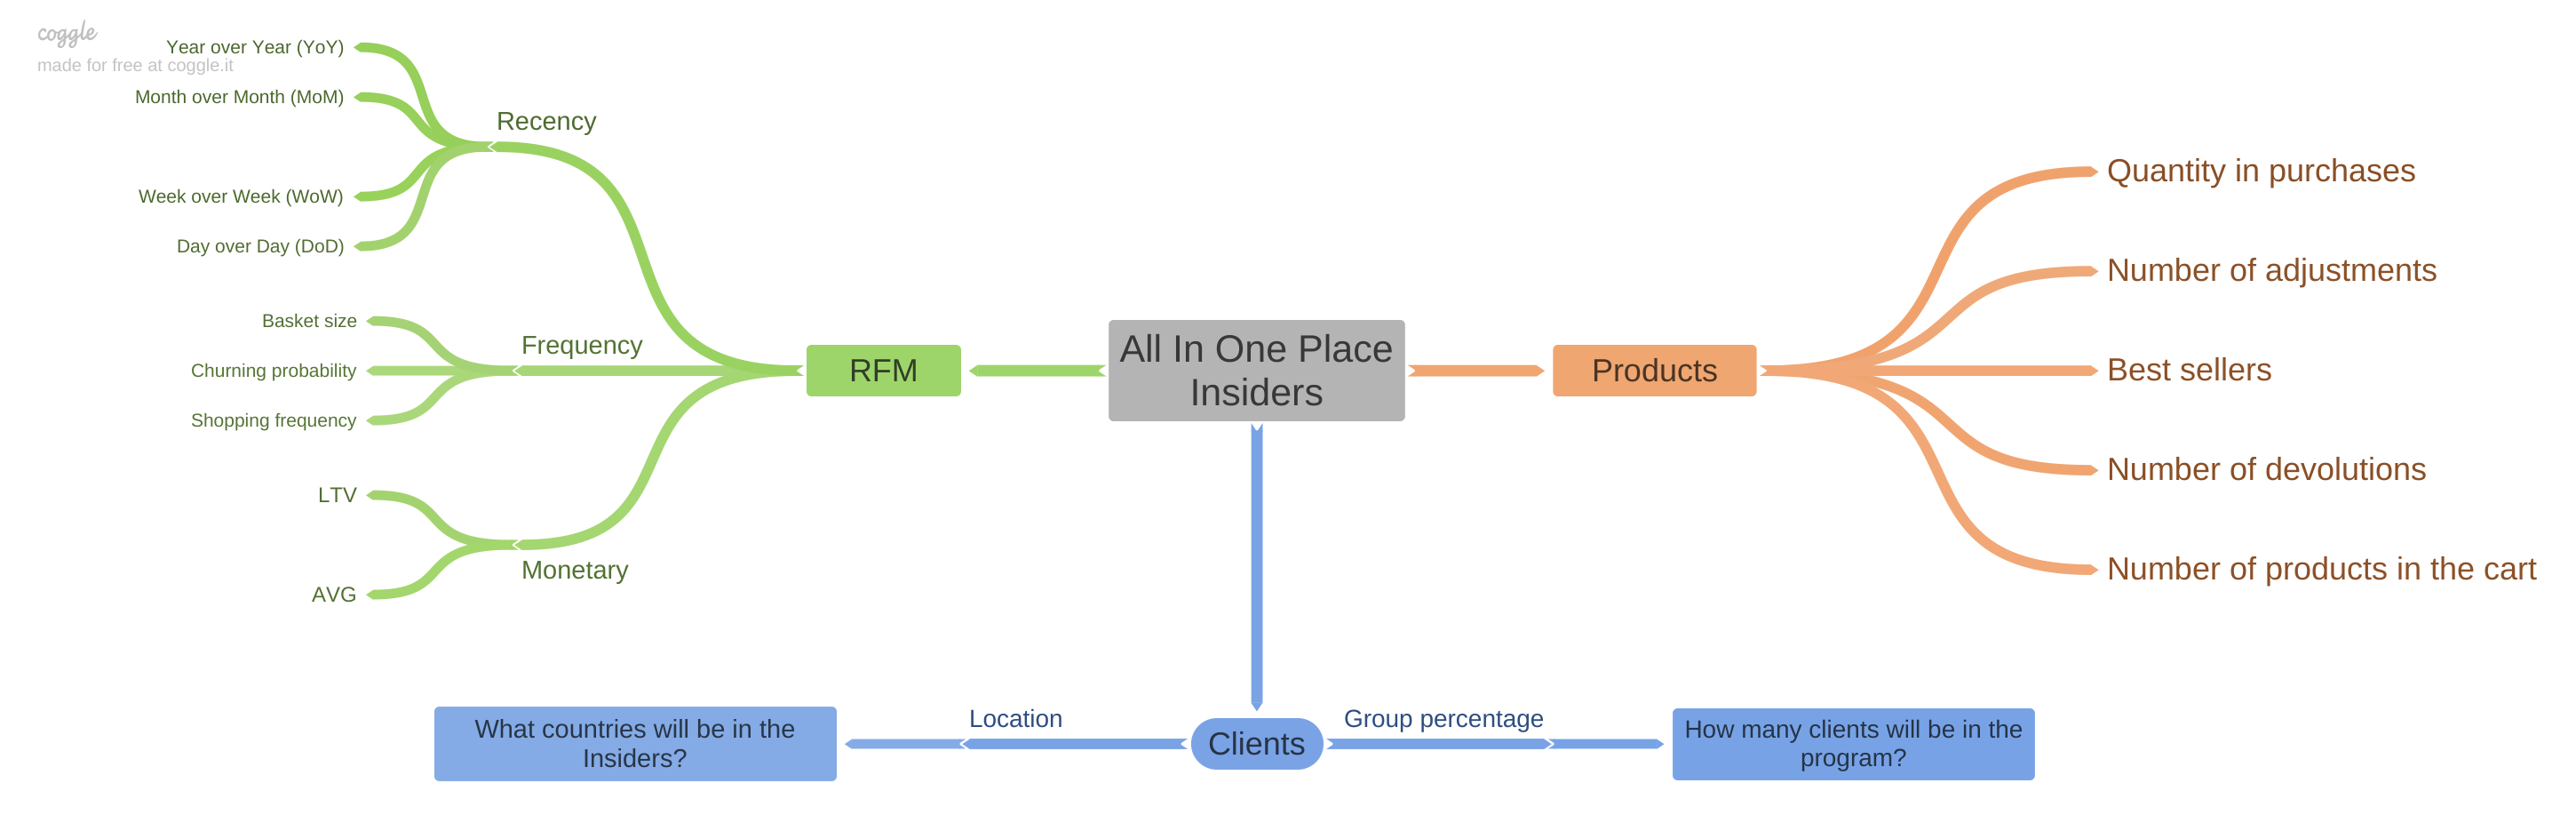

In [54]:
Image(homepath + 'reports/figures/mind_map.png')

### 4.3 Univariate Analysis

#### 4.3.1 PPR

In [55]:
df4 = df4.drop_duplicates()

In [56]:
# Pandas Proffiling Report
ppr1 = ProfileReport(df4, 'Insiders Program First Report.')
ppr1.to_file(output_file = homepath + 'reports/ppr1.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 376.85it/s]


#### 4.3.2 Invoice Week

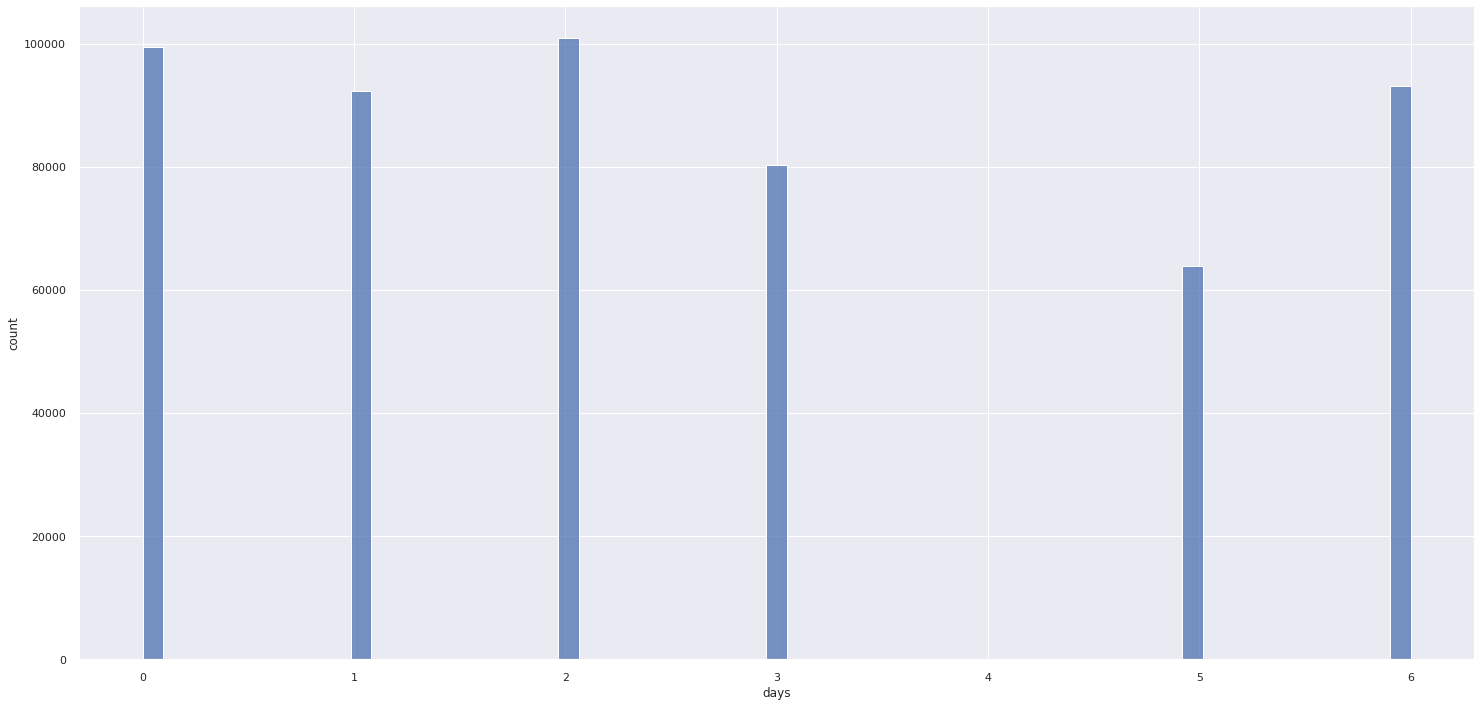

In [57]:
aux = df_purchases.loc[:, ['customer_id', 'invoice_date']]

aux['invoice_week'] = aux.loc[:, 'invoice_date'].dt.dayofweek

sns.histplot(aux['invoice_week'])
plot_label('', 'days', 'count', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/date.png')

An interesting information, this dataset has no purchases on Friday. 


Day of the week      | Value
---                  | ---
Monday               | 0
Tuesday              | 1
Wednesday            | 2
Thursday             | 3
Friday               | 4
Saturday             | 5
Sunday               | 6

#### 4.3.3 Monetary

In [58]:
df4[df4['monetary'] >= 280206].sample(1)

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_products_purchased,quantity_of_items_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,avg_recency_days
1017,14646,1.000,2076.000,280206.020,134.974,700.000,196915.000,0.206,772.000,2697.466,28.438,7.844


#### 4.3.4 Avg Ticket

In [59]:
df4[df4['avg_ticket'] >= 4453.43]

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_products_purchased,quantity_of_items_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,avg_recency_days
1262,15749,235.000,10.000,44534.300,4453.430,5.000,18028.000,0.031,9014.000,6009.333,3.333,97.000


Customer 1

In [60]:
df3[df3['customer_id'] == 15749]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
52709,15749,2017-01-09,85123A,2.550,1930,United Kingdom,540815
52710,15749,2017-01-09,21175,1.850,2000,United Kingdom,540815
52711,15749,2017-01-09,21108,2.100,3114,United Kingdom,540815
52771,15749,2017-01-09,47556B,2.550,1300,United Kingdom,540818
52772,15749,2017-01-09,48185,6.750,670,United Kingdom,540818
160141,15749,2017-04-16,48185,6.750,-670,United Kingdom,C550456
160142,15749,2017-04-16,47566B,2.550,-1300,United Kingdom,C550456
160143,15749,2017-04-16,85123A,2.550,-1930,United Kingdom,C550456
160144,15749,2017-04-16,21175,1.850,-2000,United Kingdom,C550456
160145,15749,2017-04-16,21108,2.100,-3114,United Kingdom,C550456


Customer 2

In [61]:
df3[df3['customer_id'] == 16446]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no


Customer 3

In [62]:
df3[df3['customer_id'] == 15098]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
222670,15098,2017-06-08,22502,4.950,60,United Kingdom,556442
222680,15098,2017-06-08,22502,649.500,60,United Kingdom,556444
222682,15098,2017-06-08,22502,649.500,1,United Kingdom,556446
222692,15098,2017-06-08,22502,4.950,-60,United Kingdom,C556448


#### 4.3.5 Quantity of Products Purchased

Customer 1

In [63]:
df3[df3['customer_id'] == 17841].sort_values(by = 'quantity', ascending = True).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
278383,17841,2017-07-23,23263,1.250,-10,United Kingdom,C561210
494925,17841,2017-11-21,22339,0.190,-7,United Kingdom,C578280
484964,17841,2017-11-18,23148,0.830,-7,United Kingdom,C577547
440248,17841,2017-11-02,22893,0.420,-6,United Kingdom,C574524
406915,17841,2017-10-17,23322,2.950,-5,United Kingdom,C571838


In [64]:
df3[df3['customer_id'] == 17841].sort_values(by = 'quantity', ascending = False).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
451888,17841,2017-11-07,20668,0.100,288,United Kingdom,575298
277498,17841,2017-07-23,16045,0.040,200,United Kingdom,561113
315623,17841,2017-08-26,20668,0.120,144,United Kingdom,564733
499593,17841,2017-11-22,22161,0.190,128,United Kingdom,578678
221431,17841,2017-06-07,22467,2.100,108,United Kingdom,556245


Customer 2

In [65]:
df3[df3['customer_id'] == 14911].sort_values(by = 'quantity', ascending = True).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
290364,14911,2017-08-02,22950,1.250,-288,EIRE,C562375
290363,14911,2017-08-02,22952,0.420,-240,EIRE,C562375
290359,14911,2017-08-02,23157,1.850,-240,EIRE,C562375
290366,14911,2017-08-02,22910,2.550,-200,EIRE,C562375
290367,14911,2017-08-02,22909,0.720,-192,EIRE,C562375


In [66]:
df3[df3['customer_id'] == 14911].sort_values(by = 'quantity', ascending = False).head(10)

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
408376,14911,2017-10-18,22266,0.190,640,EIRE,571937
321957,14911,2017-08-30,22950,1.250,432,EIRE,565213
321950,14911,2017-08-30,22952,0.420,360,EIRE,565213
461291,14911,2017-11-11,22909,0.720,288,EIRE,575933
282374,14911,2017-07-26,22950,1.250,288,EIRE,561645
290345,14911,2017-08-02,22950,1.250,288,EIRE,562374
446084,14911,2017-11-05,22578,0.290,264,EIRE,574874
408386,14911,2017-10-18,85078,0.190,240,EIRE,571937
408384,14911,2017-10-18,35923,0.390,240,EIRE,571937
461290,14911,2017-11-11,22952,0.420,240,EIRE,575933


Customer 3

In [67]:
df3[df3['customer_id'] == 12748].sort_values(by = 'quantity', ascending = True).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
473393,12748,2017-11-14,22071,0.500,-244,United Kingdom,C576831
473394,12748,2017-11-14,22070,0.500,-234,United Kingdom,C576831
473392,12748,2017-11-14,23055,1.000,-144,United Kingdom,C576831
473391,12748,2017-11-14,23056,1.000,-144,United Kingdom,C576831
473390,12748,2017-11-14,23057,1.000,-144,United Kingdom,C576831


In [68]:
df3[df3['customer_id'] == 12748].sort_values(by = 'quantity', ascending = False).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
460034,12748,2017-11-09,21135,0.200,576,United Kingdom,575894
420214,12748,2017-10-24,72803A,0.500,408,United Kingdom,572881
420216,12748,2017-10-24,72802C,0.500,378,United Kingdom,572881
471162,12748,2017-11-13,22071,0.500,244,United Kingdom,576623
365289,12748,2017-09-26,16218,0.060,240,United Kingdom,568703


#### 4.3.5 Number of returns

Customer 1

In [69]:
df4[df4['quantity_of_returns'] == 80995]

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_products_purchased,quantity_of_items_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,avg_recency_days


Customer 2 from avg_ticket analysis

Customer 2

In [70]:
df3[df3['customer_id'] == 12346]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
61619,12346,2017-01-16,23166,1.040,74215,United Kingdom,541431
61624,12346,2017-01-16,23166,1.040,-74215,United Kingdom,C541433


Customer 3

In [71]:
df4[df4['quantity_of_returns'] == 9014]

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_products_purchased,quantity_of_items_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,avg_recency_days
1262,15749,235.000,10.000,44534.300,4453.430,5.000,18028.000,0.031,9014.000,6009.333,3.333,97.000


In [72]:
df3[df3['customer_id'] == 15749]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
52709,15749,2017-01-09,85123A,2.550,1930,United Kingdom,540815
52710,15749,2017-01-09,21175,1.850,2000,United Kingdom,540815
52711,15749,2017-01-09,21108,2.100,3114,United Kingdom,540815
52771,15749,2017-01-09,47556B,2.550,1300,United Kingdom,540818
52772,15749,2017-01-09,48185,6.750,670,United Kingdom,540818
160141,15749,2017-04-16,48185,6.750,-670,United Kingdom,C550456
160142,15749,2017-04-16,47566B,2.550,-1300,United Kingdom,C550456
160143,15749,2017-04-16,85123A,2.550,-1930,United Kingdom,C550456
160144,15749,2017-04-16,21175,1.850,-2000,United Kingdom,C550456
160145,15749,2017-04-16,21108,2.100,-3114,United Kingdom,C550456


Customer 1 from avg_ticket analysis

### 4.4 Bivariate Analysis

#### 4.4.1 Pairplot

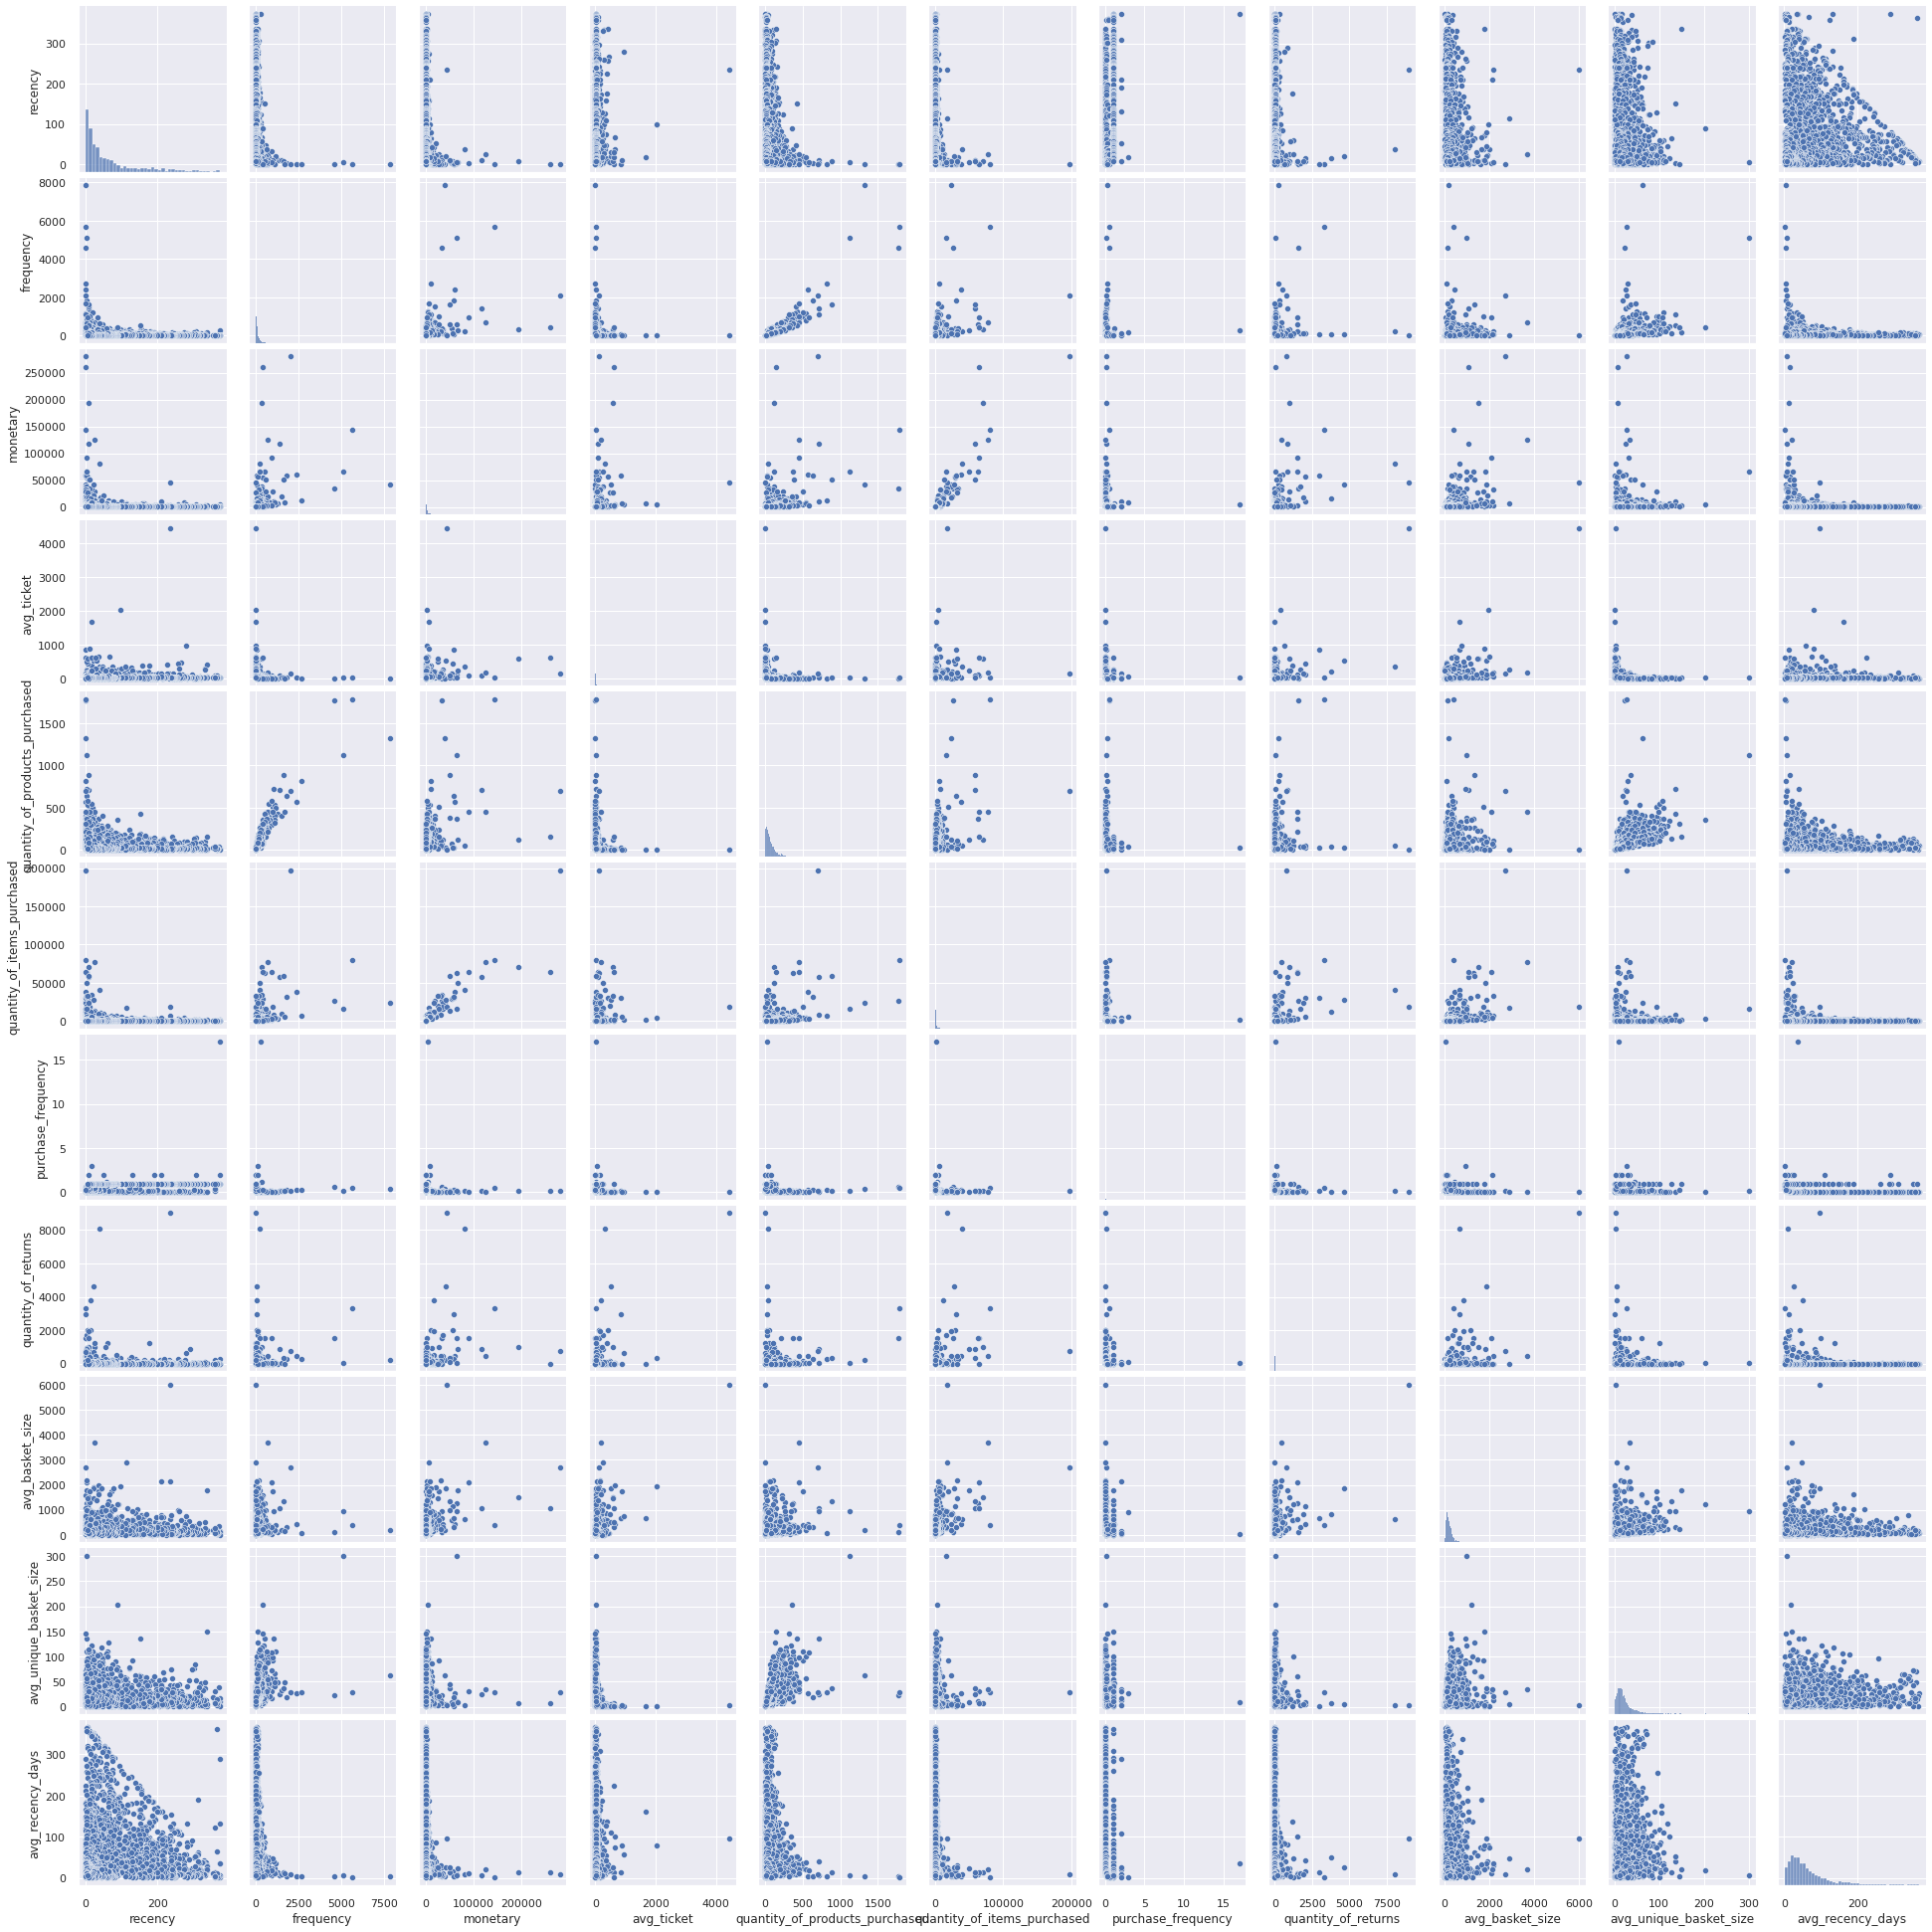

In [73]:
# pairplot
drop_cols = ['customer_id']
df4_pairplot = df4.drop(drop_cols, axis = 1)
sns.pairplot(df4_pairplot);

# saving figure
plt.savefig(homepath + 'reports/figures/pairplot.png')

**Notes**
1. Frequency has low variance
2. Avg Ticket has low variance

#### 4.4.2 The customers with highest recency are from the United Kingdom.
**FALSE** The customer with highest recency aren't from the UK.

In [74]:
aux = df_purchases.loc[:, ['customer_id', 'country']]
rfm_country = pd.merge(aux, df4, how = 'left', on = 'customer_id')


rfm_country = rfm_country[['customer_id', 'country', 'recency', 'frequency', 'monetary']]
rfm_country.columns
rfm_country['country'] = rfm_country['country'].apply(lambda x: x if x == 'United Kingdom' or x == 'Germany' 
                                                                                           or x == 'France' 
                                                                                           or x == 'EIRE' 
                                                                                           or x == 'Spain' 
                                                                                           or x == 'Netherlands'
                                                                   else 'Other countries')
rfm_country = rfm_country[rfm_country['customer_id'] < 18000]

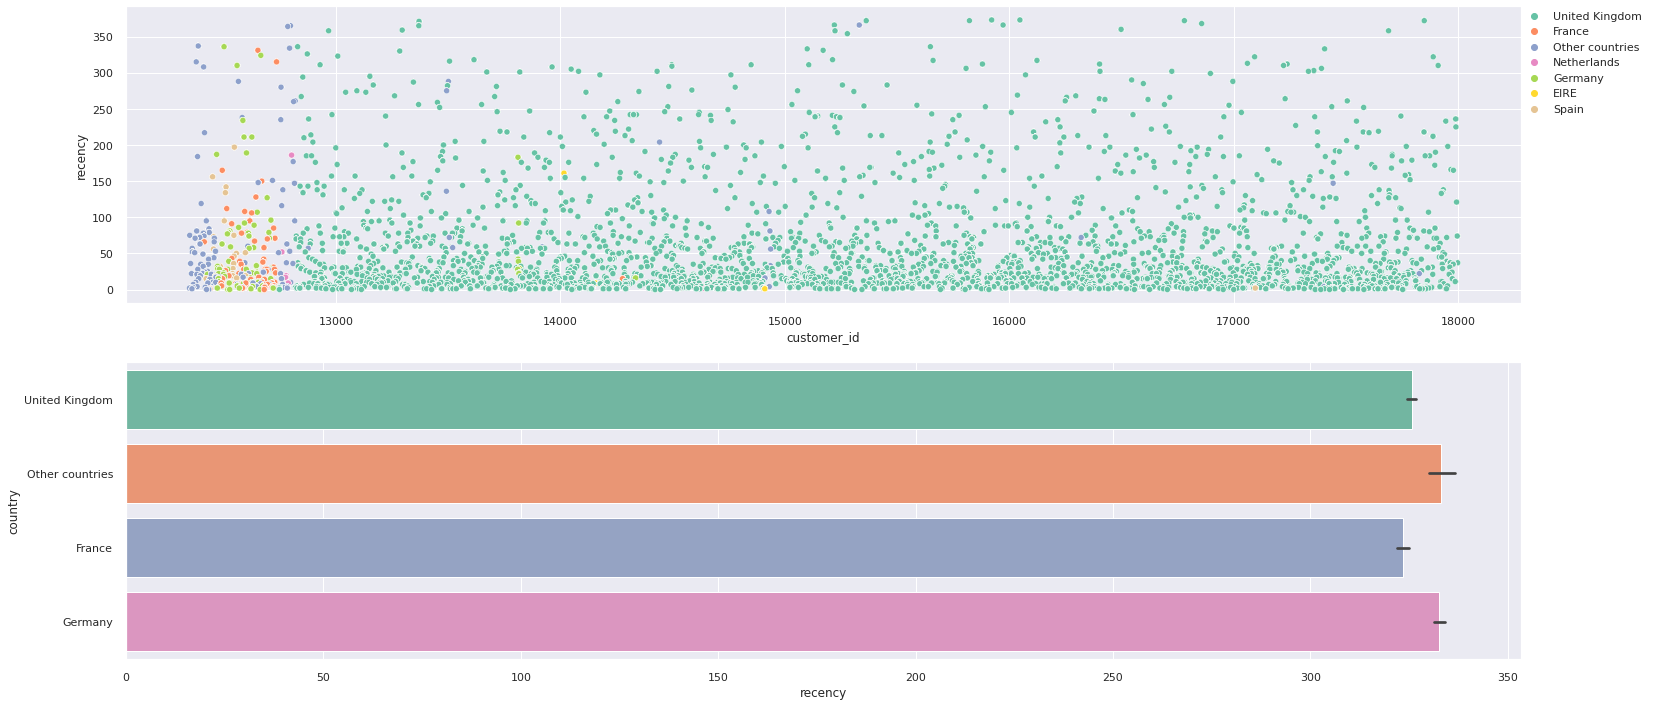

In [75]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# recency
ax = sns.scatterplot(x = 'customer_id', y = 'recency',   data = rfm_country, hue = 'country', palette = 'Set2', ax = ax1)
plot_label('', 'customer id', 'recency', 12);
ax.legend(bbox_to_anchor = (1.09, 1), loc = 'upper right', borderaxespad = 0.)

aux = rfm_country[rfm_country['recency'] >= 300]
ax = sns.barplot(x = 'recency', y = 'country', data = aux, palette = 'Set2', ax = ax2)
plot_label('', 'recency', 'country', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/country_recency.png')

#### 4.4.3 The customers with highest monetary value are from the United Kingdom.
**FALSE** The customer with highest monetary value aren't from the UK.

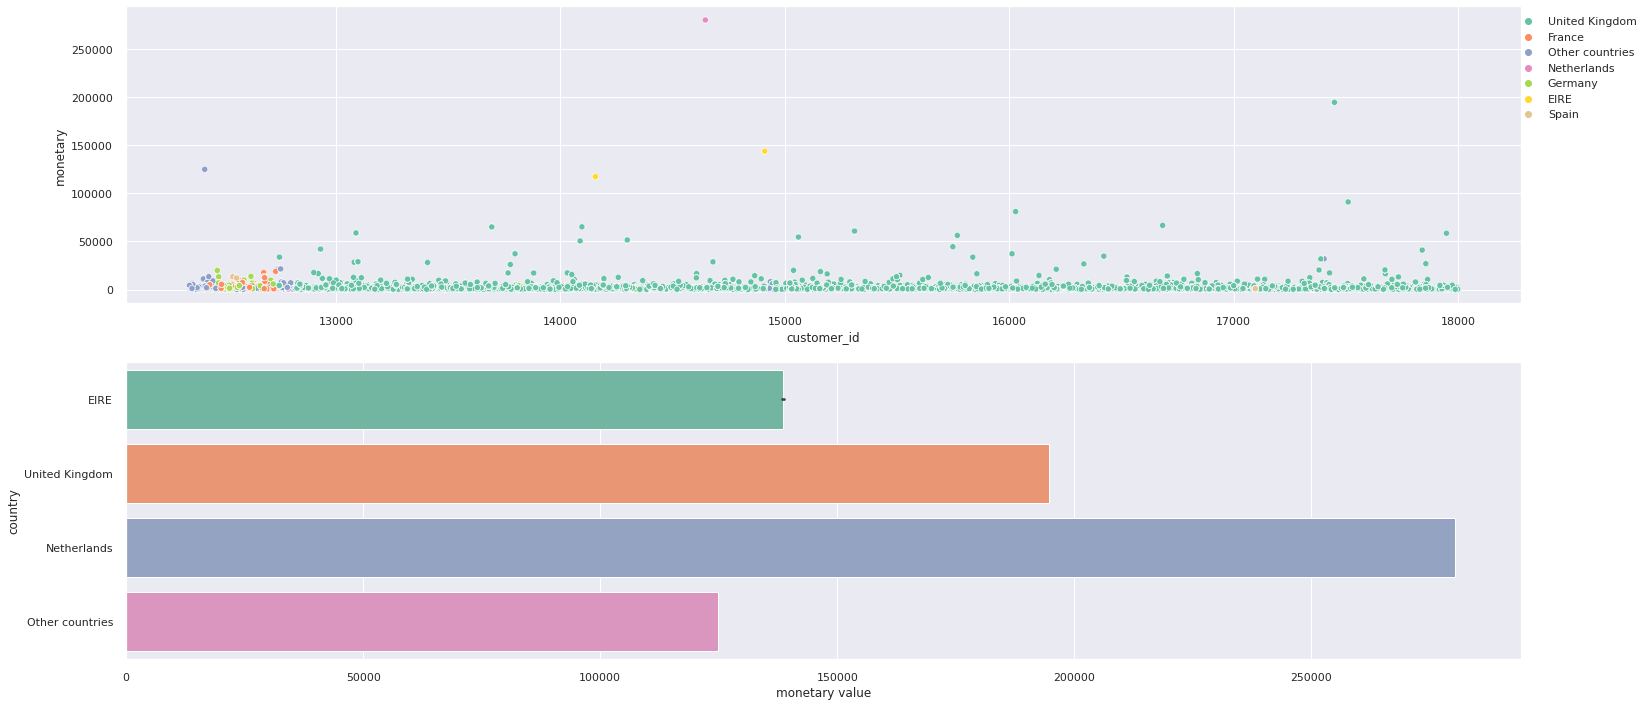

In [76]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# monetary
ax = sns.scatterplot(x = 'customer_id', y = 'monetary',   data = rfm_country, hue = 'country', palette = 'Set2', ax = ax1)
plot_label('', 'customer id', 'monetary value', 12);
ax.legend(bbox_to_anchor = (1.09, 1), loc = 'upper right')

aux = rfm_country[rfm_country['monetary'] >= 100000]
ax = sns.barplot(x = 'monetary', y = 'country', data = aux, palette = 'Set2', ax = ax2)
plot_label('', 'monetary value', 'country', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/country_monetary.png')

### 4.5 Multivariate Analysis

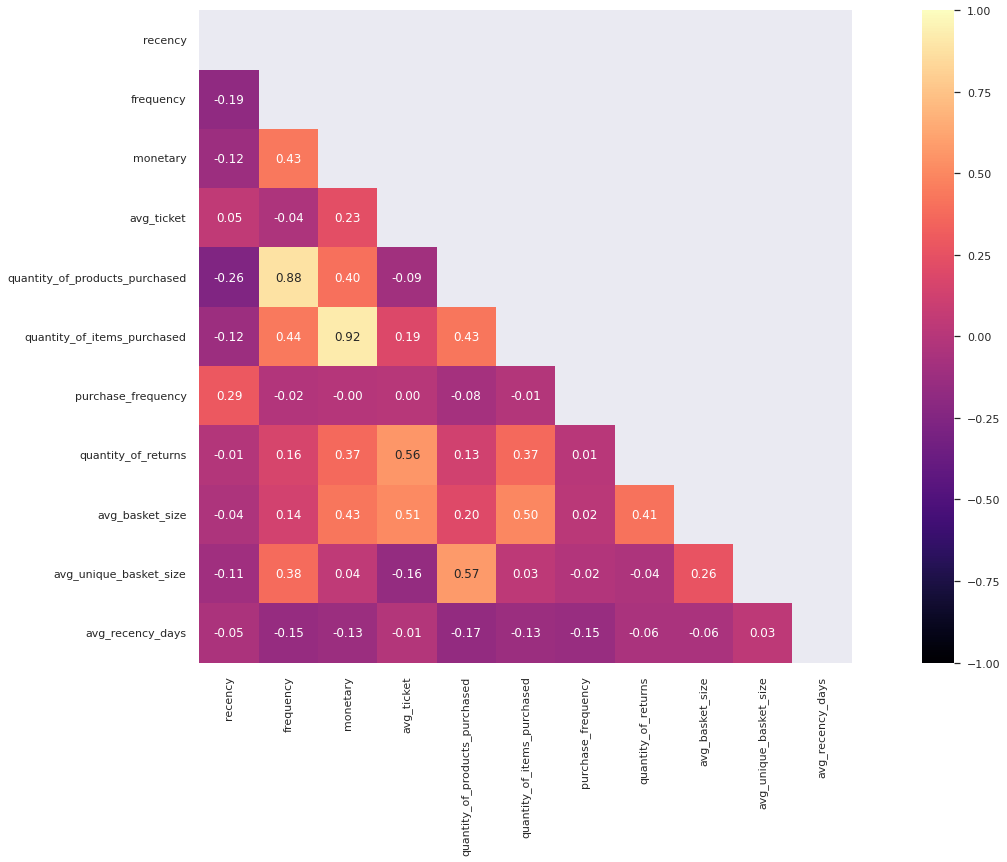

In [77]:
correlation_matrix(df4, 'customer_id', 'pearson')

# saving figure
plt.savefig(homepath + 'reports/figures/numerical_multivariate.png')

### 4.6 Dimensionality Reduction

In [80]:
pickle.dump(df4, open(homepath + 'data/processed/df4.pkl', 'wb'))
df_dr = pickle.load(open(homepath + 'data/processed/df4.pkl', 'rb'))

In [81]:
mm = pp.MinMaxScaler()

df_dr['recency']                        = mm.fit_transform(df_dr[['recency']])
df_dr['frequency']                      = mm.fit_transform(df_dr[['frequency']])
df_dr['monetary']                       = mm.fit_transform(df_dr[['monetary']])
df_dr['avg_ticket']                     = mm.fit_transform(df_dr[['avg_ticket']])
df_dr['quantity_of_products_purchased'] = mm.fit_transform(df_dr[['quantity_of_products_purchased']])
df_dr['quantity_of_items_purchased']    = mm.fit_transform(df_dr[['quantity_of_items_purchased']])
df_dr['purchase_frequency']             = mm.fit_transform(df_dr[['purchase_frequency']])
df_dr['quantity_of_returns']            = mm.fit_transform(df_dr[['quantity_of_returns']])
df_dr['avg_basket_size']                = mm.fit_transform(df_dr[['avg_basket_size']])
df_dr['avg_unique_basket_size']         = mm.fit_transform(df_dr[['avg_unique_basket_size']])
df_dr['avg_recency_days']               = mm.fit_transform(df_dr[['avg_recency_days']])

In [82]:
pickle.dump(df_dr, open(homepath + 'data/processed/df_dr.pkl', 'wb'))
X = pickle.load(open(homepath + 'data/processed/df_dr.pkl', 'rb'))

#### 4.6.1 PCA

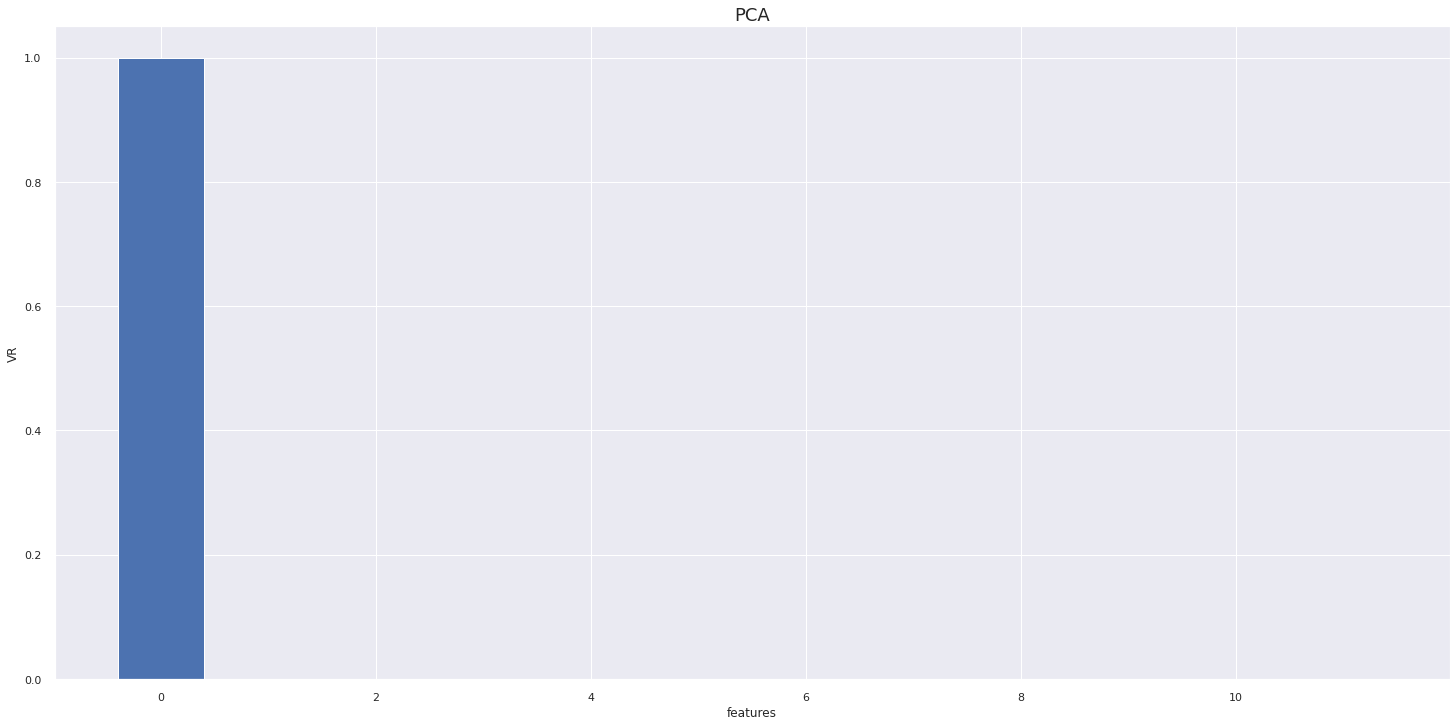

In [83]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)

# plot
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plot_label('PCA', 'features', 'VR', 12)

# pca component
df_pca = pd.DataFrame(principal_components)

# saving figure
plt.savefig(homepath + 'reports/figures/pca.png')

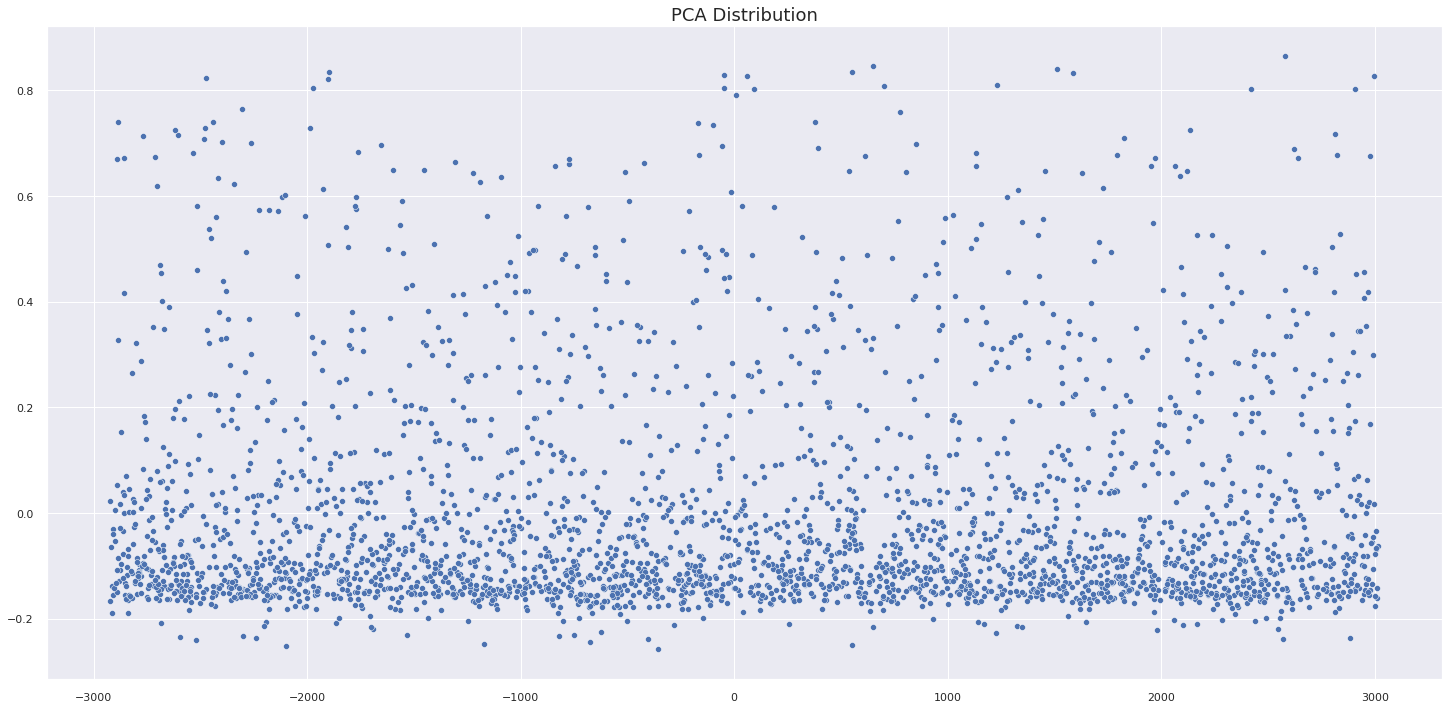

In [84]:
# plot
sns.scatterplot(x = 0, y = 1, data = df_pca);
plot_label('PCA Distribution', '', '', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/pca_distribution.png')

#### 4.6.2 UMAP

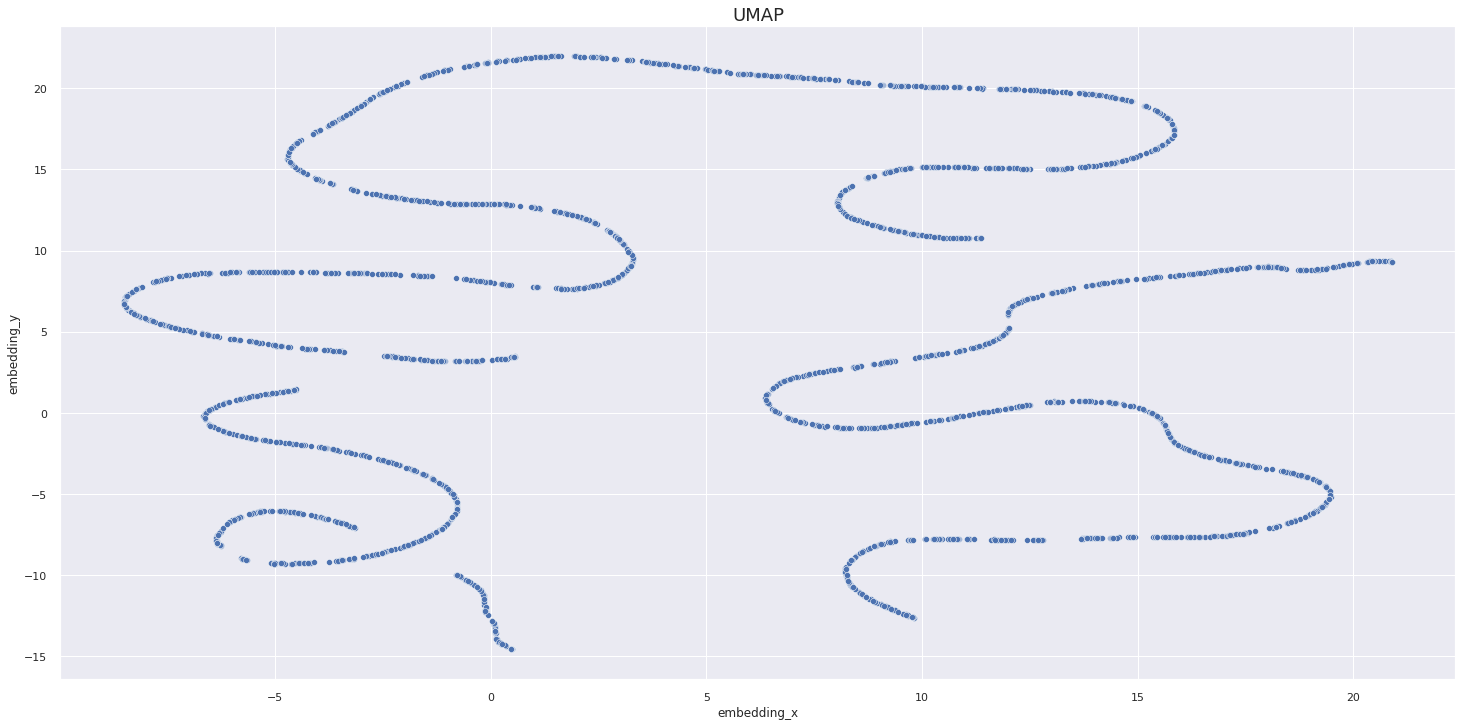

In [85]:
reducer = umap.UMAP(random_state = seed)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca);
plot_label('UMAP', 'embedding_x', 'embedding_y', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/umap.png')

#### 4.6.3 TSNE

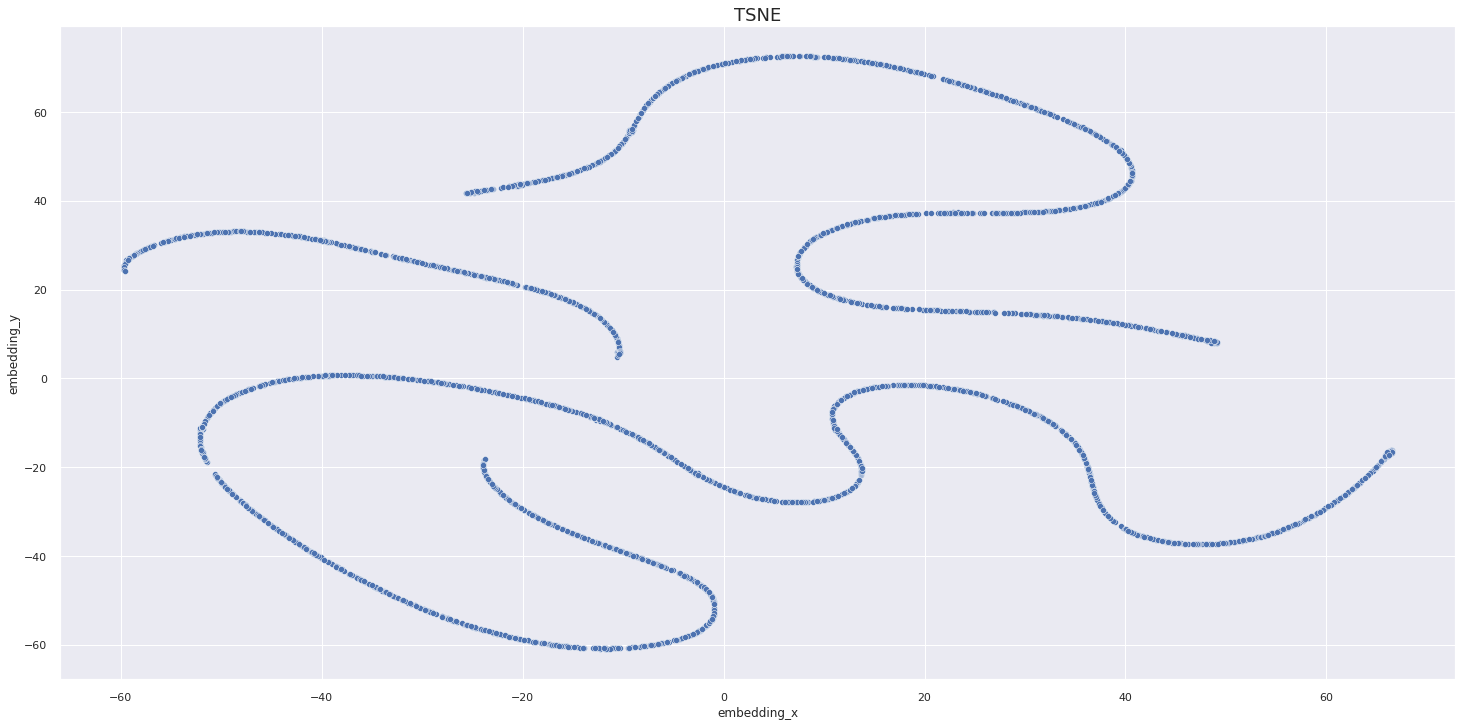

In [86]:
reducer = TSNE(n_components = 2, n_jobs = -1,random_state = seed)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca);
plot_label('TSNE', 'embedding_x', 'embedding_y', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/tsne.png')

#### 4.6.4 Tree-Based UMAP

In [87]:
# training dataset
X = df_dr.drop(['monetary'], axis = 1)
y = df_dr['monetary']

# model
rf_model = en.RandomForestRegressor(n_estimators = 100, random_state = seed)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [88]:
df_leaf = pd.DataFrame(rf_model.apply(X))

print(f'X.shape: {X.shape}\ndf_leaf.shape: {df_leaf.shape}')

X.shape: (2968, 11)
df_leaf.shape: (2968, 100)


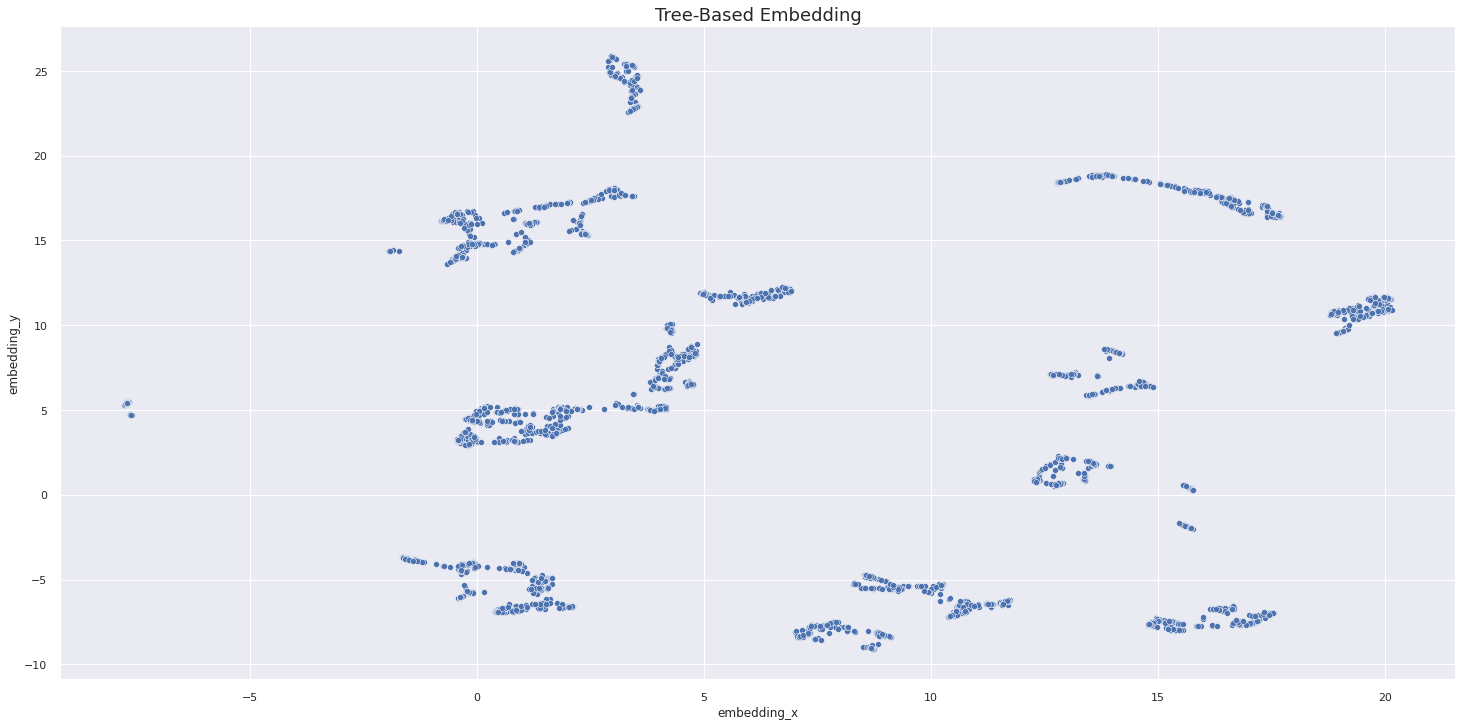

In [89]:
reducer = umap.UMAP(random_state = seed)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tree);
plot_label('Tree-Based Embedding', 'embedding_x', 'embedding_y', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/Tree-Based Embedding.png')

### 4.7 Save State

In [90]:
pickle.dump(df_tree, open(homepath + 'data/processed/df_tree.pkl', 'wb'))

## 5. HYPERPARAMETER FINE TUNING AND MODEL SELECTION

- **Tasks**
    - Dataset Checkpoint
    - Clusters
    - Model Selection
    - Final Model

### 5.1 Dataset Checkpoint

In [91]:
X = pickle.load(open(homepath + 'data/processed/df_tree.pkl', 'rb'))

In [92]:
X.head()

,embedding_x,embedding_y
0,14.194,8.336
1,12.904,0.696
2,15.243,18.254
3,1.040,3.750
4,3.325,22.580


### 5.2 Clusters

In [93]:
clusters = np.arange(2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

### 5.3 Model Selection

#### 5.3.1 K-Means

In [94]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = KMeans(n_clusters = k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = silhouette_score(X, labels)
    kmeans_list.append(sil)

#### 5.3.2 GM

In [95]:
gm_list = []
for k in clusters:
    # model definition
    gm_model = GaussianMixture(n_components = k)

    # model training
    gm_model.fit(X)

    # model predict
    labels = gm_model.predict(X)

    # model performance
    sil = silhouette_score(X, labels)
    gm_list.append(sil)

#### 5.3.3 Hierarchical Clustering

In [96]:
hc_list = []
for k in clusters:
    # model definition
    hc_model = hierarchy.linkage(X, 'ward')

    # model predict
    labels = hierarchy.fcluster(hc_model, k, criterion = 'maxclust')

    # model performance
    sil = silhouette_score(X, labels)
    hc_list.append(sil)

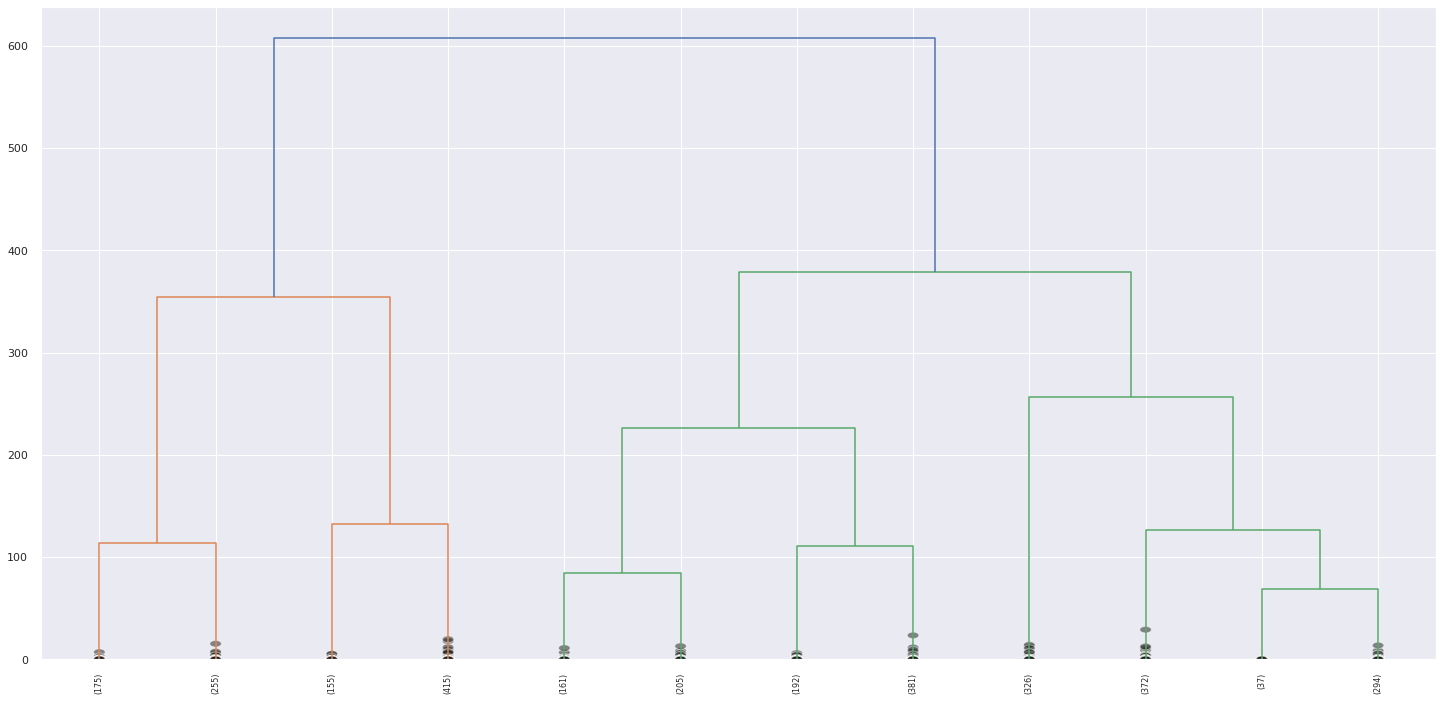

In [97]:
hierarchy.dendrogram(hc_model, truncate_mode = 'lastp', p = 12, leaf_rotation = 90, leaf_font_size = 8, show_contracted = True)
plt.plot()

# saving figure
plt.savefig(homepath + 'reports/figures/dendogram_hc.png')


#### 5.3.4 Model Comparation

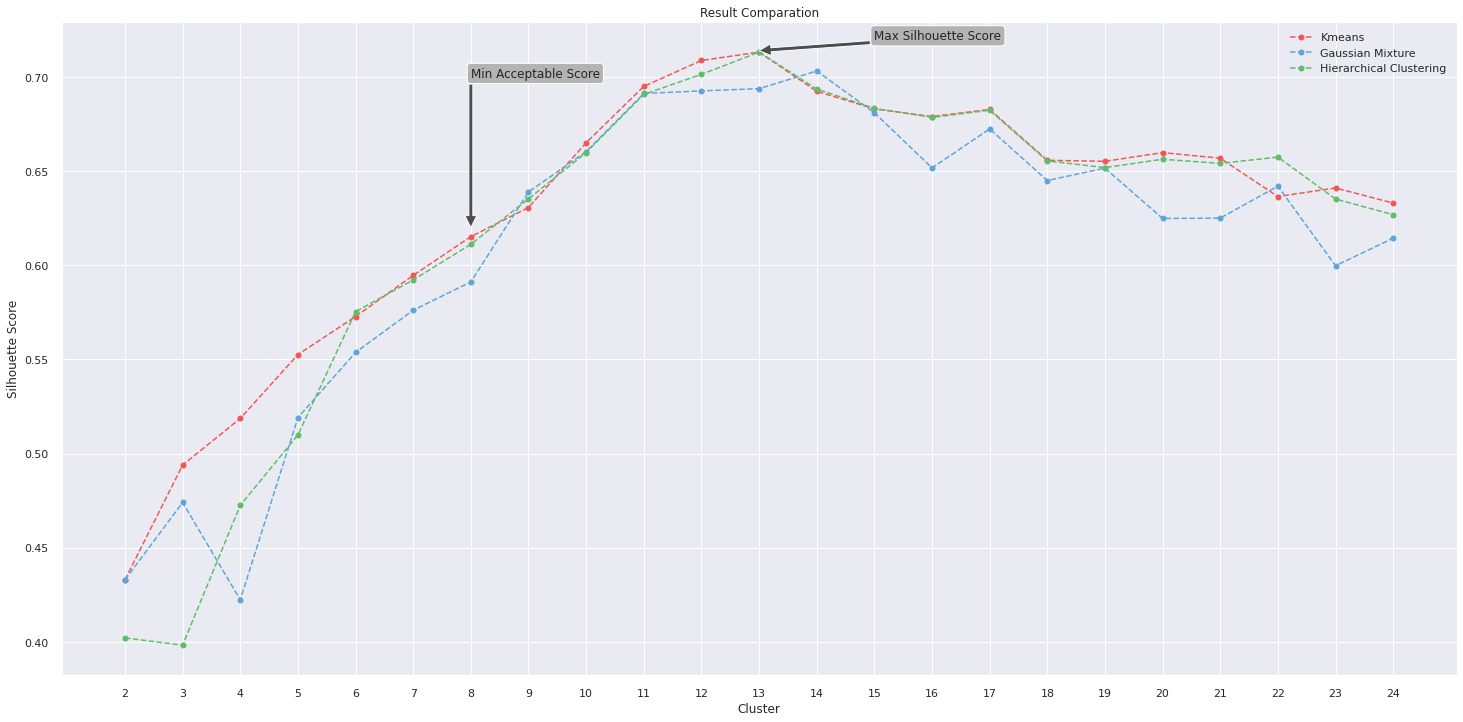

In [98]:
km_ss = silhouette_score_result(clusters, kmeans_list,'#F15854')

gm_ss = silhouette_score_result(clusters, gm_list, '#5DA5DA')

hc_ss = silhouette_score_result(clusters, hc_list, '#60BD68')

bbox = dict(boxstyle ='round', fc ='0.7')
arrowprops = dict(facecolor ='#4D4D4D')

plt.legend(['Kmeans', 'Gaussian Mixture', 'Hierarchical Clustering'])
plt.annotate('Max Silhouette Score', xy = (13, 0.714),
                xytext =(15, 0.72), 
                arrowprops = arrowprops, bbox = bbox)


plt.annotate('Min Acceptable Score', xy = (8, 0.62),
                xytext =(8, 0.7), 
                arrowprops = arrowprops, bbox = bbox)
                

# saving figure
plt.savefig(homepath + 'reports/figures/silhoette_score.png')

The highest Silhoette Score is 0.713 with 13 clusters, however, dividing customers into 13 different groups may not be very interesting a lot of cluster can make some problems for the marketing team. Considering that a score of 0.6 is a good one, we can choose between 8 and 13 clusters.

In [99]:
model_results = pd.DataFrame({  'KMeans': kmeans_list, 
                                'GM': gm_list, 
                                'HC': hc_list}).T

model_results.columns = clusters

model_results = model_results.iloc[: ,6:12]
model_results.style.highlight_max(color = '#F15854', axis = 1).highlight_min(color = '#5DA5DA', axis = 1)

,8,9,10,11,12,13
KMeans,0.615194,0.630660,0.665086,0.695002,0.708764,0.713179
GM,0.591181,0.638915,0.660350,0.691224,0.692606,0.693778
HC,0.611152,0.635248,0.659878,0.690752,0.701380,0.713191


The model with a good number of clusters and SS is a Kmeans with 9 clusters.

### 5.4 Final Model

In [100]:
#k = 9

# model definition
#final_model = KMeans(n_clusters = k)

# model training
#final_model.fit(X)

#pickle.dump(final_model, open(homepath + '/models/insiders_clustering_model.pkl', 'wb'))

## 6. CLUSTER ANALYSIS

- **Tasks**
    - Dataset Checkpoint
    - Visualization for Inspection
    - Cluster Profile

### 6.1 Dataset Checkpoint

In [101]:
df6 = pickle.load(open(homepath + 'data/processed/df_tree.pkl', 'rb'))

final_model = pickle.load(open(homepath + '/models/insiders_clustering_model.pkl', 'rb'))
# create a col with the clusters
labels = final_model.predict(X)
df6['clusters'] = labels

df6.head()

,embedding_x,embedding_y,clusters
0,14.194,8.336,5
1,12.904,0.696,5
2,15.243,18.254,3
3,1.040,3.750,2
4,3.325,22.580,8


### 6.2 Visualization Inspection

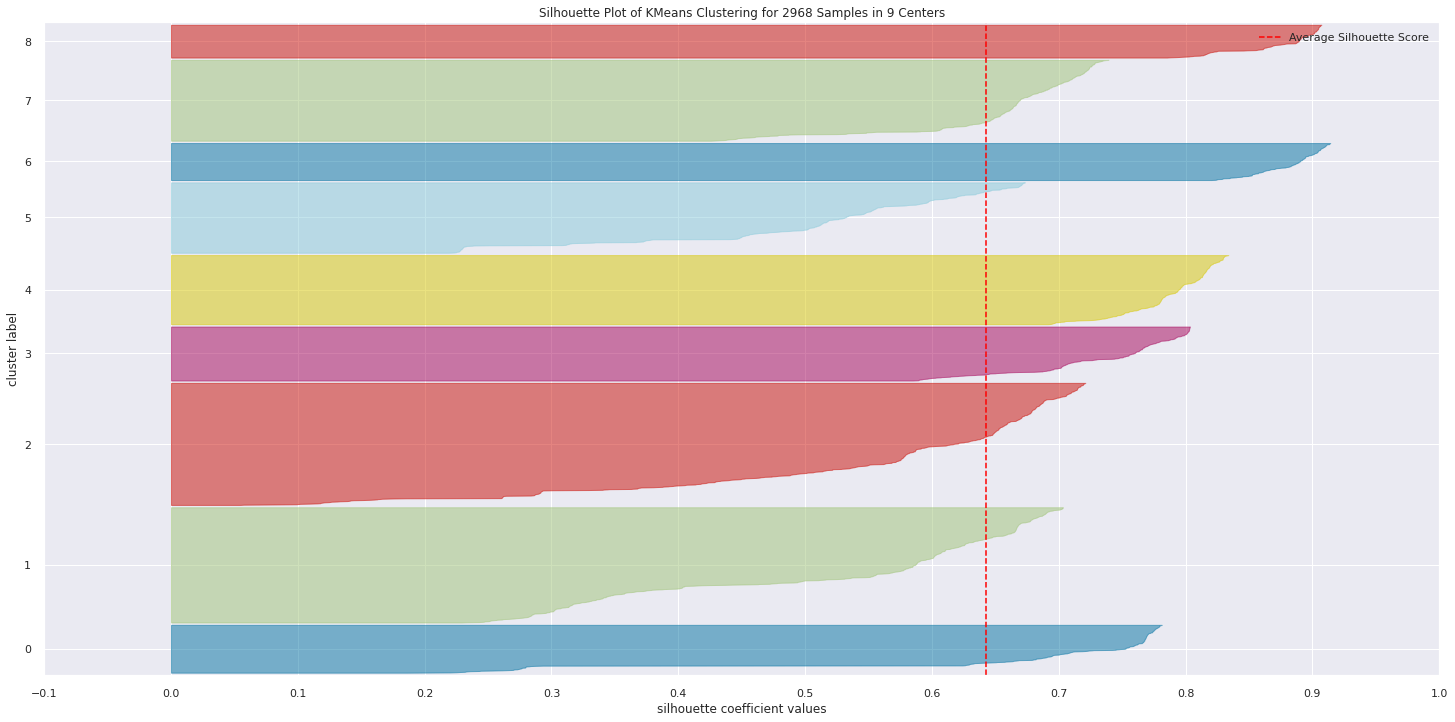

In [102]:
visualizer = SilhouetteVisualizer(final_model, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

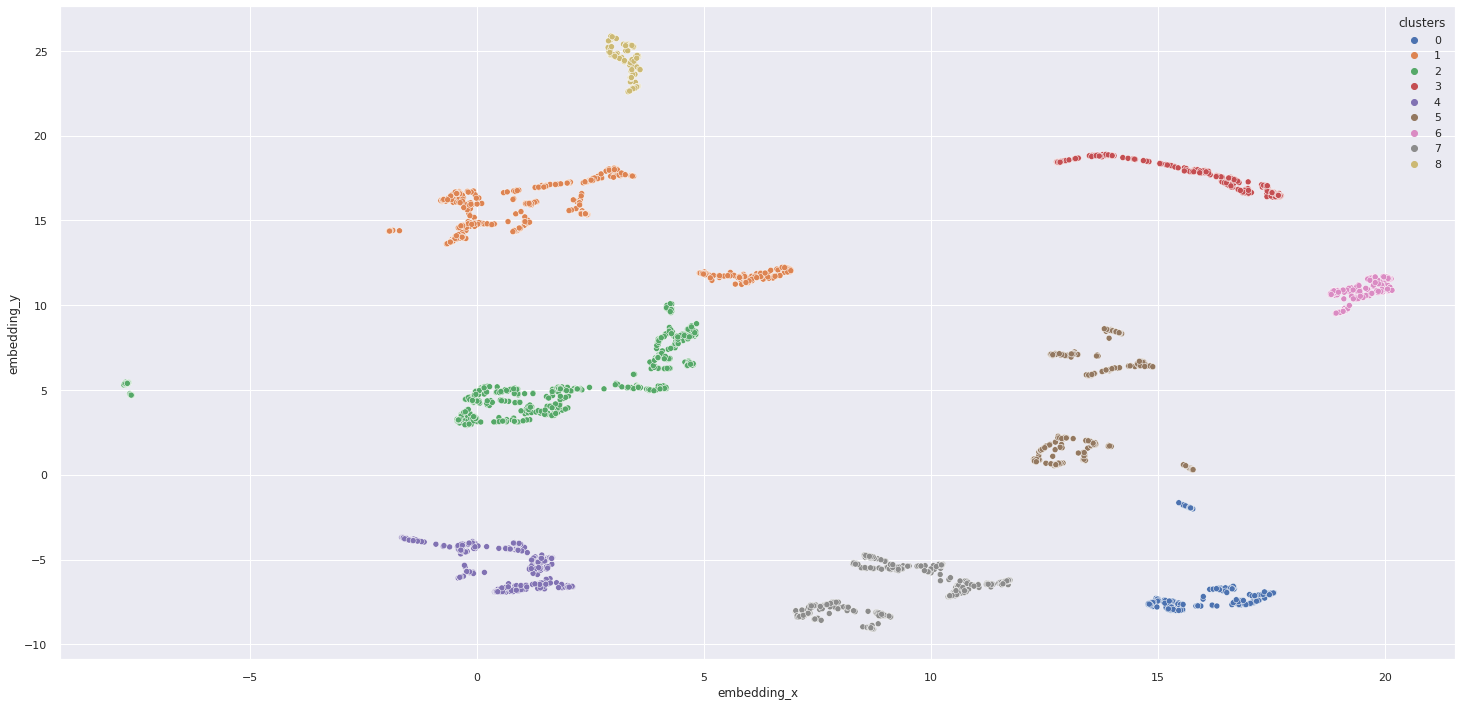

In [103]:
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', hue = 'clusters', data = df6, palette = 'deep')

# saving figure
plt.savefig(homepath + 'reports/figures/clusters.png')

### 6.3 Cluster Profile

#### 6.3.1 Clusters Info

In [113]:
clusters_info = pickle.load(open(homepath + 'data/processed/df4.pkl', 'rb'))
clusters_info['cluster'] = labels
clusters_info.head()

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_products_purchased,quantity_of_items_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,avg_recency_days,cluster
0,17850,372.000,297.000,5391.210,18.152,21.000,1733.000,17.000,40.000,50.971,8.735,35.500,5
1,13047,31.000,172.000,3237.540,18.823,106.000,1391.000,0.029,36.000,139.100,17.200,27.250,5
2,12583,2.000,247.000,7281.380,29.479,115.000,5060.000,0.040,51.000,337.333,16.467,23.188,3
3,13748,95.000,28.000,948.250,33.866,24.000,439.000,0.018,0.000,87.800,5.600,92.667,2
4,15100,333.000,3.000,876.000,292.000,1.000,80.000,0.073,22.000,26.667,1.000,8.600,8


In [114]:
# number of customers
df_cluster = clusters_info[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# avg_recency
df_avg_recency = clusters_info[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how = 'inner', on = 'cluster')

# avg_frequency
df_avg_frequency = clusters_info[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how = 'inner', on = 'cluster')

#avg_monetary
df_avg_monetary = clusters_info[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, how = 'inner', on = 'cluster')

# quantity_of_products_purchased
df_q_products = clusters_info[['quantity_of_products_purchased', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_q_products, how = 'inner', on = 'cluster')


# quantity_of_items_purchased
df_q_items = clusters_info[['quantity_of_items_purchased', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_q_items, how = 'inner', on = 'cluster')

# quantity_of_returns
df_q_returns = clusters_info[['quantity_of_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_q_returns, how = 'inner', on = 'cluster')

df_cluster

,cluster,customer_id,perc_customer,recency,frequency,monetary,quantity_of_products_purchased,quantity_of_items_purchased,quantity_of_returns
0,0,226,7.615,41.093,105.040,1935.592,79.491,1164.527,28.239
1,1,543,18.295,103.934,33.239,450.625,29.013,195.385,5.107
2,2,575,19.373,72.843,126.527,4971.699,68.762,2836.216,86.677
3,3,255,8.592,21.863,338.118,7961.159,175.690,4844.690,83.263
4,4,326,10.984,61.623,76.276,1089.254,61.144,589.387,15.521
5,5,332,11.186,40.123,172.313,2701.576,118.931,1615.991,24.377
6,6,175,5.896,26.954,229.046,3969.624,147.097,2327.554,37.274
7,7,381,12.837,49.512,106.404,1511.516,80.609,849.430,13.840
8,8,155,5.222,130.187,14.084,223.382,12.871,67.774,8.039


#### 6.3.2 Report

| Nº |      Name      |
| -- | -------------- |
| 03 |    Insiders    |
| 05 |   More Items   |
| 07 |  More Shopping |
| 01 |    Underdog    |
| 08 |   Less 0.5k    |
| 04 |  More Products |
| 06 | Need Attention |
| 00 |   Need a Push  |
| 02 |     Midway     |

In [115]:
df_cluster['cluster'] = df_cluster['cluster'].apply(lambda x: 'Insiders' if x == 3 else
                                                              'More Items' if x == 5 else
                                                              'More Shopping' if x == 7 else
                                                              'Underdog' if x == 1 else
                                                              'Less 0.5k' if x == 8 else
                                                              'More Products' if x == 4 else
                                                              'Need Attention' if x == 6 else
                                                              'Need a Push' if x == 0 else 'Midway')

- **Cluster Insiders**
    - Number of customers: 255 (8.591% of customers)
    - Average Recency: 22 days
    - Average Frequency: 0.074
    - Average Monetary: $7961.159
- **Cluster Midway**
    - Number of customers: 575 (19.373% of customers)
    - Average Recency: 73 days
    - Average Frequency: 0.107
    - Average Monetary: $4971.699
- **Cluster Need Attention**
    - Number of customers: 175 (5.896% of customers)
    - Average Recency: 27 days
    - Average Frequency: 0.037
    - Average Monetary: $3969.624
- **Cluster More Items**
    - Number of customers: 332 (11.187% of customers)
    - Average Recency: 40 days
    - Average Frequency: 0.088
    - Average Monetary: $2701.573
- **Cluster Need a Push**
    - Number of customers: 226 (7.614% of customers)
    - Average Recency:  41 days 
    - Average Frequency: 0.043
    - Average Monetary: $1932.592
- **Cluster More Shopping**
    - Number of customers: 381 (12.838% of customers)
    - Average Recency: 50 days
    - Average Frequency: 0.054
    - Average Monetary: $1511.516
- **Cluster More Products**
    - Number of customers: 326 (10.984% of customers)
    - Average Recency: 62 days
    - Average Frequency: 0.0.67
    - Average Monetary: $1089.254
- **Cluster Underdog**
    - Number of customers: 543 (18.295% of customers)
    - Average Recency: 104 days 
    - Average Frequency: 0.204
    - Average Monetary: $450.625
- **Cluster Less 0.5k**
    - Number of customers: 155 (5.222% of customers)
    - Average Recency: 130 days
    - Average Frequency: 0.378
    - Average Monetary: $223.382





### 6.4 Save State

In [116]:
pickle.dump(clusters_info, open(homepath + 'data/processed/clusters_info.pkl', 'wb'))
pickle.dump(df_cluster, open(homepath + 'data/processed/df_cluster.pkl', 'wb'))

## 7. CLUSTERS EDA

### H1. The Insiders Cluster has 10% of the total GMV or above.
**True:** The insiders cluster has 24.98% of the total GMV.

In [130]:
h1_insiders = clusters_info.loc[clusters_info['cluster'] == 3,'monetary'].sum()

h1_total = clusters_info.loc[:, 'monetary'].sum()

h1 = round(100*h1_insiders/h1_total, 2)
print(f'GMV: {h1}%')

GMV: 24.98%


### H2. The Insiders Cluster has 10% of the total products sales or above.
**True:** The insiders cluster has 18.99% of the total of products sales.

In [131]:
h2_insiders = clusters_info.loc[clusters_info['cluster'] == 3,'quantity_of_products_purchased'].sum()

h2_total = clusters_info.loc[:, 'quantity_of_products_purchased'].sum()

h2 = round(100*h2_insiders/h2_total, 2)
print(f'Insiders Sales: {h2}%')

Insiders Sales: 18.99%


### H3. The Insiders Cluster customers have,at least, a median revenue 200% higher if compared with all costumers.
**True:** The customers of the insiders cluster have a median revenue 600.46% above.

In [133]:
h3_insiders = clusters_info.loc[clusters_info['cluster'] == 3,'monetary'].median()

h3_total = clusters_info.loc[:, 'monetary'].median()

h3 = round(100*h3_insiders/h3_total, 2)
print(f'Median diff: {h3}%')

Median diff: 600.46%


### H4. The Insiders Cluster GMV is concentrated in the third quartile.
**False:** It's in the first quartile

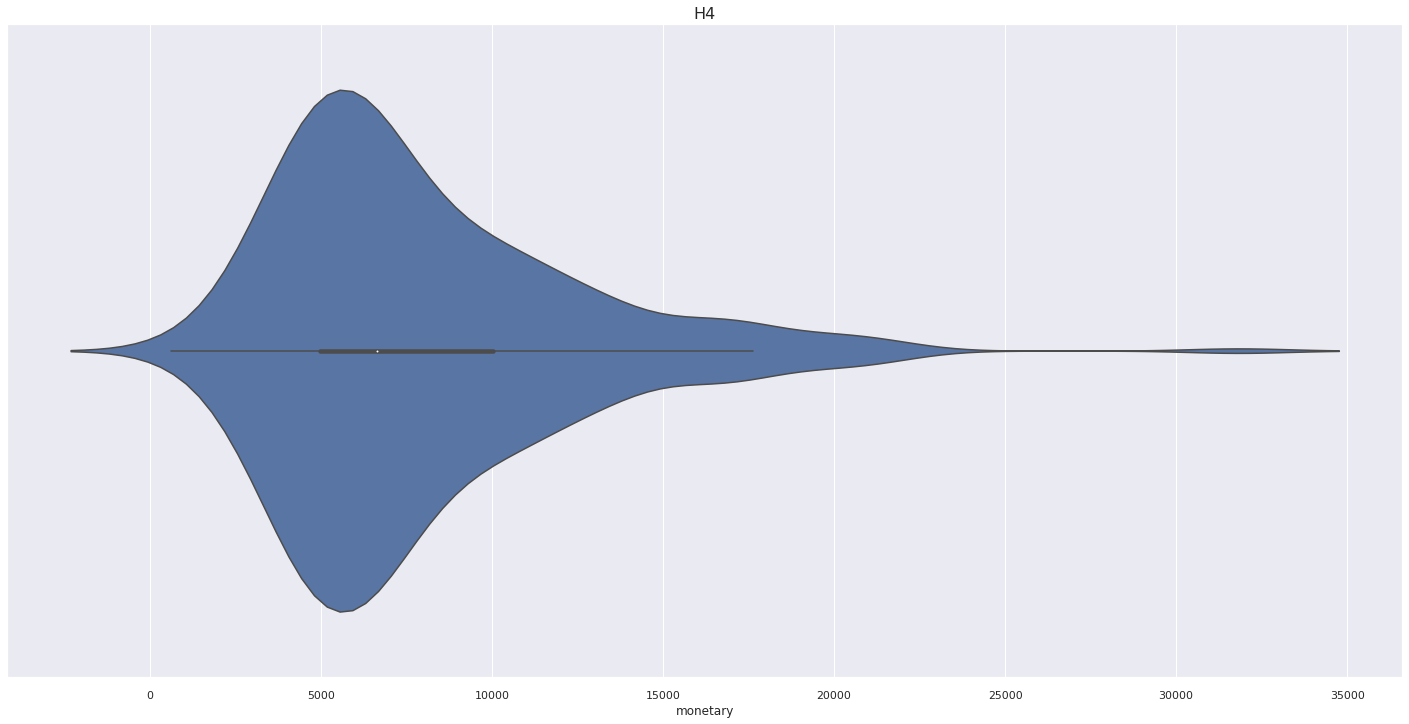

In [143]:
h4 = clusters_info.loc[clusters_info['cluster'] == 3, 'monetary']
h4_plot = sns.violinplot(h4)
h4_plot.set_xlabel('monetary', fontsize = 12);
h4_plot.set_title('H4', fontsize = 16);

### H5. The Insiders Cluster has an avg return lower than all clusters.
**False:** The Insiders Cluster has an avg return higher than avg mean of all clusters.

In [147]:
h5_insiders = round(clusters_info.loc[clusters_info['cluster'] == 3,'quantity_of_returns'].mean(), 2)

h5_total = round(clusters_info.loc[:, 'quantity_of_returns'].mean(), 2)

print(f'Avg Return Insiders: {h5_insiders} \nAvg Return All Clusters: {h5_total}')

Avg Return Insiders: 83.26 
Avg Return All Clusters: 35.86


## 8. BUSSINESS PERFORMANCE

### 1. Who are the elegible people to participate in the “Insiders Program”?

In [121]:
clusters_info.loc[clusters_info['cluster'] == 3, 'customer_id'].sample(5)

508     13599
828     14415
275     17243
2       12583
2255    13340
Name: customer_id, dtype: int64

### 2. How many clients will be part of the group?


In [122]:
size = clusters_info.loc[clusters_info['cluster'] == 3, 'customer_id'].size

print(f'The insiders cluster has {size} customers.')

The insiders cluster has 255 customers.


### 3. Which are the main caracteristics for the group?

- **Cluster Insiders**
    - Number of customers: 255 (8.591% of customers)
    - Average Recency: 22 days
    - Average Frequency: 0.074
    - Average Monetary: $7961.159

### 4. What is the revenue percentage that comes from the group?

In [123]:
aux = df_cluster[df_cluster['cluster'] == 'Insiders']

insiders_percent_revenue = round(aux['monetary'].sum()*100/df_cluster['monetary'].sum(), 2)
print(f'The insiders clustering revenue percentage is {insiders_percent_revenue}%')

The insiders clustering revenue percentage is 32.08%


### 5 Which are the guarantees that the “Insiders Program” is better than the rest of the base?

In [120]:
df_cluster.sort_values('monetary', ascending = False)

,cluster,customer_id,perc_customer,recency,frequency,monetary,quantity_of_products_purchased,quantity_of_items_purchased,quantity_of_returns
3,Insiders,255,8.592,21.863,338.118,7961.159,175.690,4844.690,83.263
2,Midway,575,19.373,72.843,126.527,4971.699,68.762,2836.216,86.677
6,Need Attention,175,5.896,26.954,229.046,3969.624,147.097,2327.554,37.274
5,More Items,332,11.186,40.123,172.313,2701.576,118.931,1615.991,24.377
0,Need a Push,226,7.615,41.093,105.040,1935.592,79.491,1164.527,28.239
7,More Shopping,381,12.837,49.512,106.404,1511.516,80.609,849.430,13.840
4,More Products,326,10.984,61.623,76.276,1089.254,61.144,589.387,15.521
1,Underdog,543,18.295,103.934,33.239,450.625,29.013,195.385,5.107
8,Less 0.5k,155,5.222,130.187,14.084,223.382,12.871,67.774,8.039


Using the RFM Model as a metric, the Insiders Group has 32.08% of the total revenue of all clusters, has the highest frequency and the best recency.